In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
!pip install rdkit
!pip install shap
!pip install xgboost
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00


In [ ]:
# import packages and modules

from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, Descriptors, AllChem
from rdkit.Chem.Draw import IPythonConsole
from itertools import combinations
import IPython
from IPython.display import display, Image as IPImage
from PIL import Image
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import re
from rdkit import Chem
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, cohen_kappa_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import pickle
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Read Excel file

#sheet_names = pd.ExcelFile("D:\Dataset_koyel\CDRI_preprocessed.xlsx").sheet_names
#print(sheet_names)

train_df = pd.read_excel('/content/drive/MyDrive/HOB/Dataset_CDRI.xlsx', sheet_name = "Dataset")
print(train_df.shape)

#print(df_first.head(5))
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns


(721, 9)


In [ ]:
test_df = pd.read_excel('/content/drive/MyDrive/HOB/Testing_drug.xlsx', sheet_name = "test_data_pka_class")
print(test_df.shape)

(45, 9)


In [ ]:
# Data cleaning Preprocessing of the half life. Removed hours, around, approximtely, approx sign. Replaced "-" and "–" to "to"

train_df['Half Life (hrs-1)'] = train_df['Half Life (hrs-1)'].apply(lambda x: re.sub(r'[≈<~]|\bhours?\.?\b|\bhr\b|\bh\b|\babout|\baround|\bapproximately|\bapprox|\bApproximately|\bbetween', '', str(x), flags=re.IGNORECASE))
train_df = train_df.apply(lambda x: str(x).strip() if isinstance(x, str) else x) #Remove space in starting and ending
train_df['Half Life (hrs-1)'] = train_df['Half Life (hrs-1)'].apply(lambda x: x.replace("-", " to ") if isinstance(x, str) else x) # Replace - with 'to'
train_df['Half Life (hrs-1)'] = train_df['Half Life (hrs-1)'].apply(lambda x: x.replace("–", " to ") if isinstance(x, str) else x) # Replace – with 'to'

#print(train_df['Half Life (hrs-1)'])

In [ ]:
# Data cleaning Preprocessing of the half life. Removed hours, around, approximtely, approx sign. Replaced "-" and "–" to "to"

test_df['Half Life (hrs-1)'] = test_df['Half Life (hrs-1)'].apply(lambda x: re.sub(r'[≈<~]|\bhours?\b|\bhrs\b', '', str(x), flags=re.IGNORECASE))
test_df = test_df.apply(lambda x: str(x).strip() if isinstance(x, str) else x) #Remove space in starting and ending
test_df['Half Life (hrs-1)'] = test_df['Half Life (hrs-1)'].apply(lambda x: x.replace("-", " to ") if isinstance(x, str) else x) # Replace - with 'to'
test_df['Half Life (hrs-1)'] = test_df['Half Life (hrs-1)'].apply(lambda x: x.replace("–", " to ") if isinstance(x, str) else x) # Replace – with 'to'

#print(test_df['Half Life (hrs-1)'])

In [ ]:
def convert_to_hours(value):
    if 'to' in value:
        min_value, second = map(str, value.split(' to'))
        if 'days' in second:
            max_value, string = map(str, second.split(' days'))
            average_value = ((float(min_value) + float(max_value)) / 2) *24  # Convert days to hours
            return average_value
        elif 'day' in second:
            max_value, string = map(str, second.split(' day'))
            average_value = ((float(min_value) + float(max_value)) / 2) * 24  # Convert day to hours
            return average_value
        elif 'minutes' in second:
            max_value, string = map(str, second.split(' minutes'))
            average_value = ((float(min_value) + float(max_value)) / 2) / 60  # Convert minutes to hours
            return average_value
        elif 'min' in second:
            max_value, string = map(str, second.split(' min'))
            average_value = ((float(min_value) + float(max_value)) / 2) / 60  # Convert minutes to hours
            return average_value
        elif 'weeks' in second:
            max_value, string = map(str, second.split(' weeks'))
            average_value = ((float(min_value) + float(max_value)) / 2) * 7 * 24  # Convert weeks to hours
            return average_value
        else:
            average_value = ((float(min_value) + float(second)) / 2)
            return average_value
    elif '±' in value:
        min_value, string = map(str, value.split('±'))
        return min_value
    elif 'minutes' in value:
        return float(value.split()[0]) / 60
    elif 'min' in value:
        return float(value.split()[0]) / 60
    elif 'seconds' in value:
        return float(value.split()[0]) / 3600
    elif 'days' in value:
        return float(value.split()[0]) * 24
    elif 'day' in value:
        return float(value.split()[0]) * 24
    elif 'months' in value:
        return float(value.split()[0]) * 30 * 24
    elif 'weeks' in value:
        return float(value.split()[0]) * 7 * 24
    elif 'week' in value:
        return float(value.split()[0]) * 7 * 24
    elif 'years' in value:
        return float(value.split()[0]) * 365 * 24
    else:
        return value

train_df['Half Life (hrs-1)'] = train_df['Half Life (hrs-1)'].apply(convert_to_hours)
test_df['Half Life (hrs-1)'] = test_df['Half Life (hrs-1)'].apply(convert_to_hours)
#print(df['Half Life (hrs-1)'])

In [ ]:
#Preprocessing the Oral Bioavailability column
train_df['Oral Bioavailability'] = train_df['Oral Bioavailability'].apply(lambda x: re.sub(r'[≥]|\babove', '', str(x)))
train_df['Oral Bioavailability'] = train_df['Oral Bioavailability'].apply(lambda x: x.replace("-", " to ") if isinstance(x, str) else x) # Replace - with 'to'
train_df['Oral Bioavailability'] = train_df['Oral Bioavailability'].apply(lambda x: x.replace("–", " to ") if isinstance(x, str) else x) # Replace – with 'to'
#print(df['Oral Bioavailability'])

In [ ]:
# Define two classes
bio_lower_thresh = 19 #class 0
bio_upper_thresh = 20 #class 1

def class_define(value, bio_lower_thresh, bio_upper_thresh):
    value = str(value)
    if 'to' in value:
        min_value, max_value = map(str, value.split('to'))
        if float(min_value) <= bio_lower_thresh and float(max_value) <= bio_lower_thresh:
            return 0
        elif float(min_value) >= bio_upper_thresh and float(max_value) >= bio_upper_thresh:
            return 1
        else:
            return -1
    else:
        if float(value) >= bio_upper_thresh:
            return 1
        else:
            return 0


train_df['Class'] = train_df['Oral Bioavailability'].apply(lambda x: class_define(x, bio_lower_thresh, bio_upper_thresh))
test_df['Class'] = test_df['Oral Bioavailability'].apply(lambda x: class_define(x, bio_lower_thresh, bio_upper_thresh))

#dropped_df = original_df[original_df['Class'] == -1].reset_index(drop=True)
#df = original_df[original_df['Class'] != -1].reset_index(drop=True)



In [ ]:
# Remove ~

train_df['M.Wt'] = train_df['M.Wt'].apply(lambda x: re.sub(r'[~]', '', str(x), flags=re.IGNORECASE))
test_df['M.Wt'] = test_df['M.Wt'].apply(lambda x: re.sub(r'[~]', '', str(x), flags=re.IGNORECASE))

with pd.ExcelWriter('/content/drive/MyDrive/HOB/Rerun/intermediate_result.xlsx', engine='openpyxl') as writer:
    train_df.to_excel(writer, sheet_name='train_ready_data', index=False)

with pd.ExcelWriter('/content/drive/MyDrive/HOB/Rerun/intermediate_result.xlsx', engine='openpyxl', mode = 'a') as writer:
    test_df.to_excel(writer, sheet_name='test_data', index=False)

column_to_remove = 'Oral Bioavailability'  # Specify the name of the column you want to remove
train_updated_df = train_df.drop(columns=[column_to_remove])
test_updated_df = test_df.drop(columns=[column_to_remove])

with pd.ExcelWriter('/content/drive/MyDrive/HOB/Rerun/intermediate_result.xlsx',engine='openpyxl', mode='a') as writer:
    train_updated_df.to_excel(writer, sheet_name='train_data_cnn', index=False)

with pd.ExcelWriter('/content/drive/MyDrive/HOB/Rerun/intermediate_result.xlsx',engine='openpyxl', mode='a') as writer:
    test_updated_df.to_excel(writer, sheet_name='test_data_cnn', index=False)


In [ ]:
# To see the structure of drugs

def show_smiles_train(smiles):
    molecules = [Chem.MolFromSmiles(smile) for smile in smiles]
    #print(molecules)
    img = Draw.MolsToGridImage(molecules[:20], molsPerRow=5, subImgSize=(400,400),
                               legends=[f'LogP: {round(x, 2)}' for x in train_df['Log P']])
    display("Click on the photo to zoom it")
    display(IPImage("/content/drive/MyDrive/HOB/Rerun/molecules.png"))  # Use the renamed Image class



show_smiles_train(train_df["Structure (SMILES)"])



'Click on the photo to zoom it'

FileNotFoundError: No such file or directory: '/content/drive/MyDrive/HOB/Rerun/molecules.png'

FileNotFoundError: No such file or directory: '/content/drive/MyDrive/HOB/Rerun/molecules.png'

<IPython.core.display.Image object>

In [ ]:
chosen_descriptors = ['BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v',
                      'EState_VSA1', 'EState_VSA10', 'EState_VSA11', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6',
                      'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'ExactMolWt', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3',
                      'FractionCSP3', 'HallKierAlpha', 'HeavyAtomCount', 'HeavyAtomMolWt', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA',
                      'MaxAbsEStateIndex', 'MaxAbsPartialCharge', 'MaxEStateIndex', 'MaxPartialCharge', 'MinAbsEStateIndex', 'MinAbsPartialCharge',
                      'MinEStateIndex', 'MinPartialCharge', 'MolLogP', 'MolMR', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles',
                      'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings',
                      'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRadicalElectrons',  'NumSaturatedCarbocycles',
                      'NumSaturatedHeterocycles', 'NumSaturatedRings', 'NumValenceElectrons', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12',
                      'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9',
                      'RingCount', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8',
                      'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5',
                      'SlogP_VSA6', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'TPSA', 'VSA_EState1', 'VSA_EState10', 'VSA_EState2', 'VSA_EState3',
                      'VSA_EState4', 'VSA_EState5', 'VSA_EState6', 'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'fr_Al_COO', 'fr_Al_OH',
                      'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO',
                      'fr_C_S', 'fr_HOCCN', 'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole',
                      'fr_SH', 'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide', 'fr_amidine', 'fr_aniline',
                      'fr_aryl_methyl', 'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzene', 'fr_benzodiazepine', 'fr_bicyclic', 'fr_diazo',
                      'fr_dihydropyridine', 'fr_epoxide', 'fr_ester', 'fr_ether', 'fr_furan', 'fr_guanido', 'fr_halogen', 'fr_hdrzine', 'fr_hdrzone',
                      'fr_imidazole', 'fr_imide', 'fr_isocyan', 'fr_isothiocyan', 'fr_ketone', 'fr_ketone_Topliss', 'fr_lactam', 'fr_lactone',
                      'fr_methoxy', 'fr_morpholine', 'fr_nitrile', 'fr_nitro', 'fr_nitro_arom', 'fr_nitro_arom_nonortho', 'fr_nitroso', 'fr_oxazole',
                      'fr_oxime', 'fr_para_hydroxylation', 'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_phos_acid', 'fr_phos_ester', 'fr_piperdine',
                      'fr_piperzine', 'fr_priamide', 'fr_prisulfonamd', 'fr_pyridine', 'fr_quatN', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone',
                      'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene', 'fr_unbrch_alkane', 'fr_urea', 'qed']
#'NumRotatableBonds',  'MolWt',
smiles_string = train_df["Structure (SMILES)"]
# Define a function to compute topological features from SMILES
def compute_topological_features(smiles, chosen_descriptors):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    mol_descriptor_calculator = MolecularDescriptorCalculator(chosen_descriptors)
    list_of_descriptor_vals = list(mol_descriptor_calculator.CalcDescriptors(mol))
    #print(list_of_descriptor_vals)
    return list_of_descriptor_vals

data = [compute_topological_features(smiles, chosen_descriptors) for smiles in smiles_string]
descriptors_df = pd.DataFrame(data, columns = chosen_descriptors)
#descriptors_df.insert(0, "Drug_name", descriptors_df.iloc[:, 0])

with pd.ExcelWriter('/content/drive/MyDrive/HOB/Rerun/intermediate_result.xlsx', engine='openpyxl', mode='a') as writer:
    descriptors_df.to_excel(writer, sheet_name='descriptors', index=False)
#print(descriptors_df)

[12:27:40] DEPRECATION WARNING: please use MorganGenerator
[12:27:40] DEPRECATION WARNING: please use MorganGenerator
[12:27:40] DEPRECATION WARNING: please use MorganGenerator
[12:27:40] DEPRECATION WARNING: please use MorganGenerator
[12:27:40] DEPRECATION WARNING: please use MorganGenerator
[12:27:40] DEPRECATION WARNING: please use MorganGenerator
[12:27:40] DEPRECATION WARNING: please use MorganGenerator
[12:27:40] DEPRECATION WARNING: please use MorganGenerator
[12:27:40] DEPRECATION WARNING: please use MorganGenerator
[12:27:40] DEPRECATION WARNING: please use MorganGenerator
[12:27:40] DEPRECATION WARNING: please use MorganGenerator
[12:27:40] DEPRECATION WARNING: please use MorganGenerator
[12:27:40] DEPRECATION WARNING: please use MorganGenerator
[12:27:40] DEPRECATION WARNING: please use MorganGenerator
[12:27:40] DEPRECATION WARNING: please use MorganGenerator
[12:27:40] DEPRECATION WARNING: please use MorganGenerator
[12:27:40] DEPRECATION WARNING: please use MorganGenerat

In [ ]:
len(chosen_descriptors)

198

In [ ]:
# Assuming df is your DataFrame
col_thresh = 20
column_sums = descriptors_df.sum(axis=0)  # Calculate column-wise sum

# Filter out columns with sum as 0
non_zero_sum_columns = column_sums[column_sums != 0].index
descriptors_df_filtered = descriptors_df[non_zero_sum_columns]
zero_percentage = (descriptors_df_filtered == 0).sum() / len(descriptors_df_filtered) * 100

# Drop columns where the percentage of zeros exceeds col_thresh
columns_to_keep = zero_percentage[zero_percentage <= col_thresh].index
descriptors_df_filtered = descriptors_df[columns_to_keep ]

print(descriptors_df_filtered.shape)

#descriptors_df_filtered.to_csv('D:\Dataset_koyel\smiles2descriptors_filtered.csv', index = False)

with pd.ExcelWriter('/content/drive/MyDrive/HOB/Rerun/intermediate_result.xlsx', engine='openpyxl', mode='a') as writer:
    descriptors_df_filtered.to_excel(writer, sheet_name='filtered_descriptors', index=False)

(721, 69)


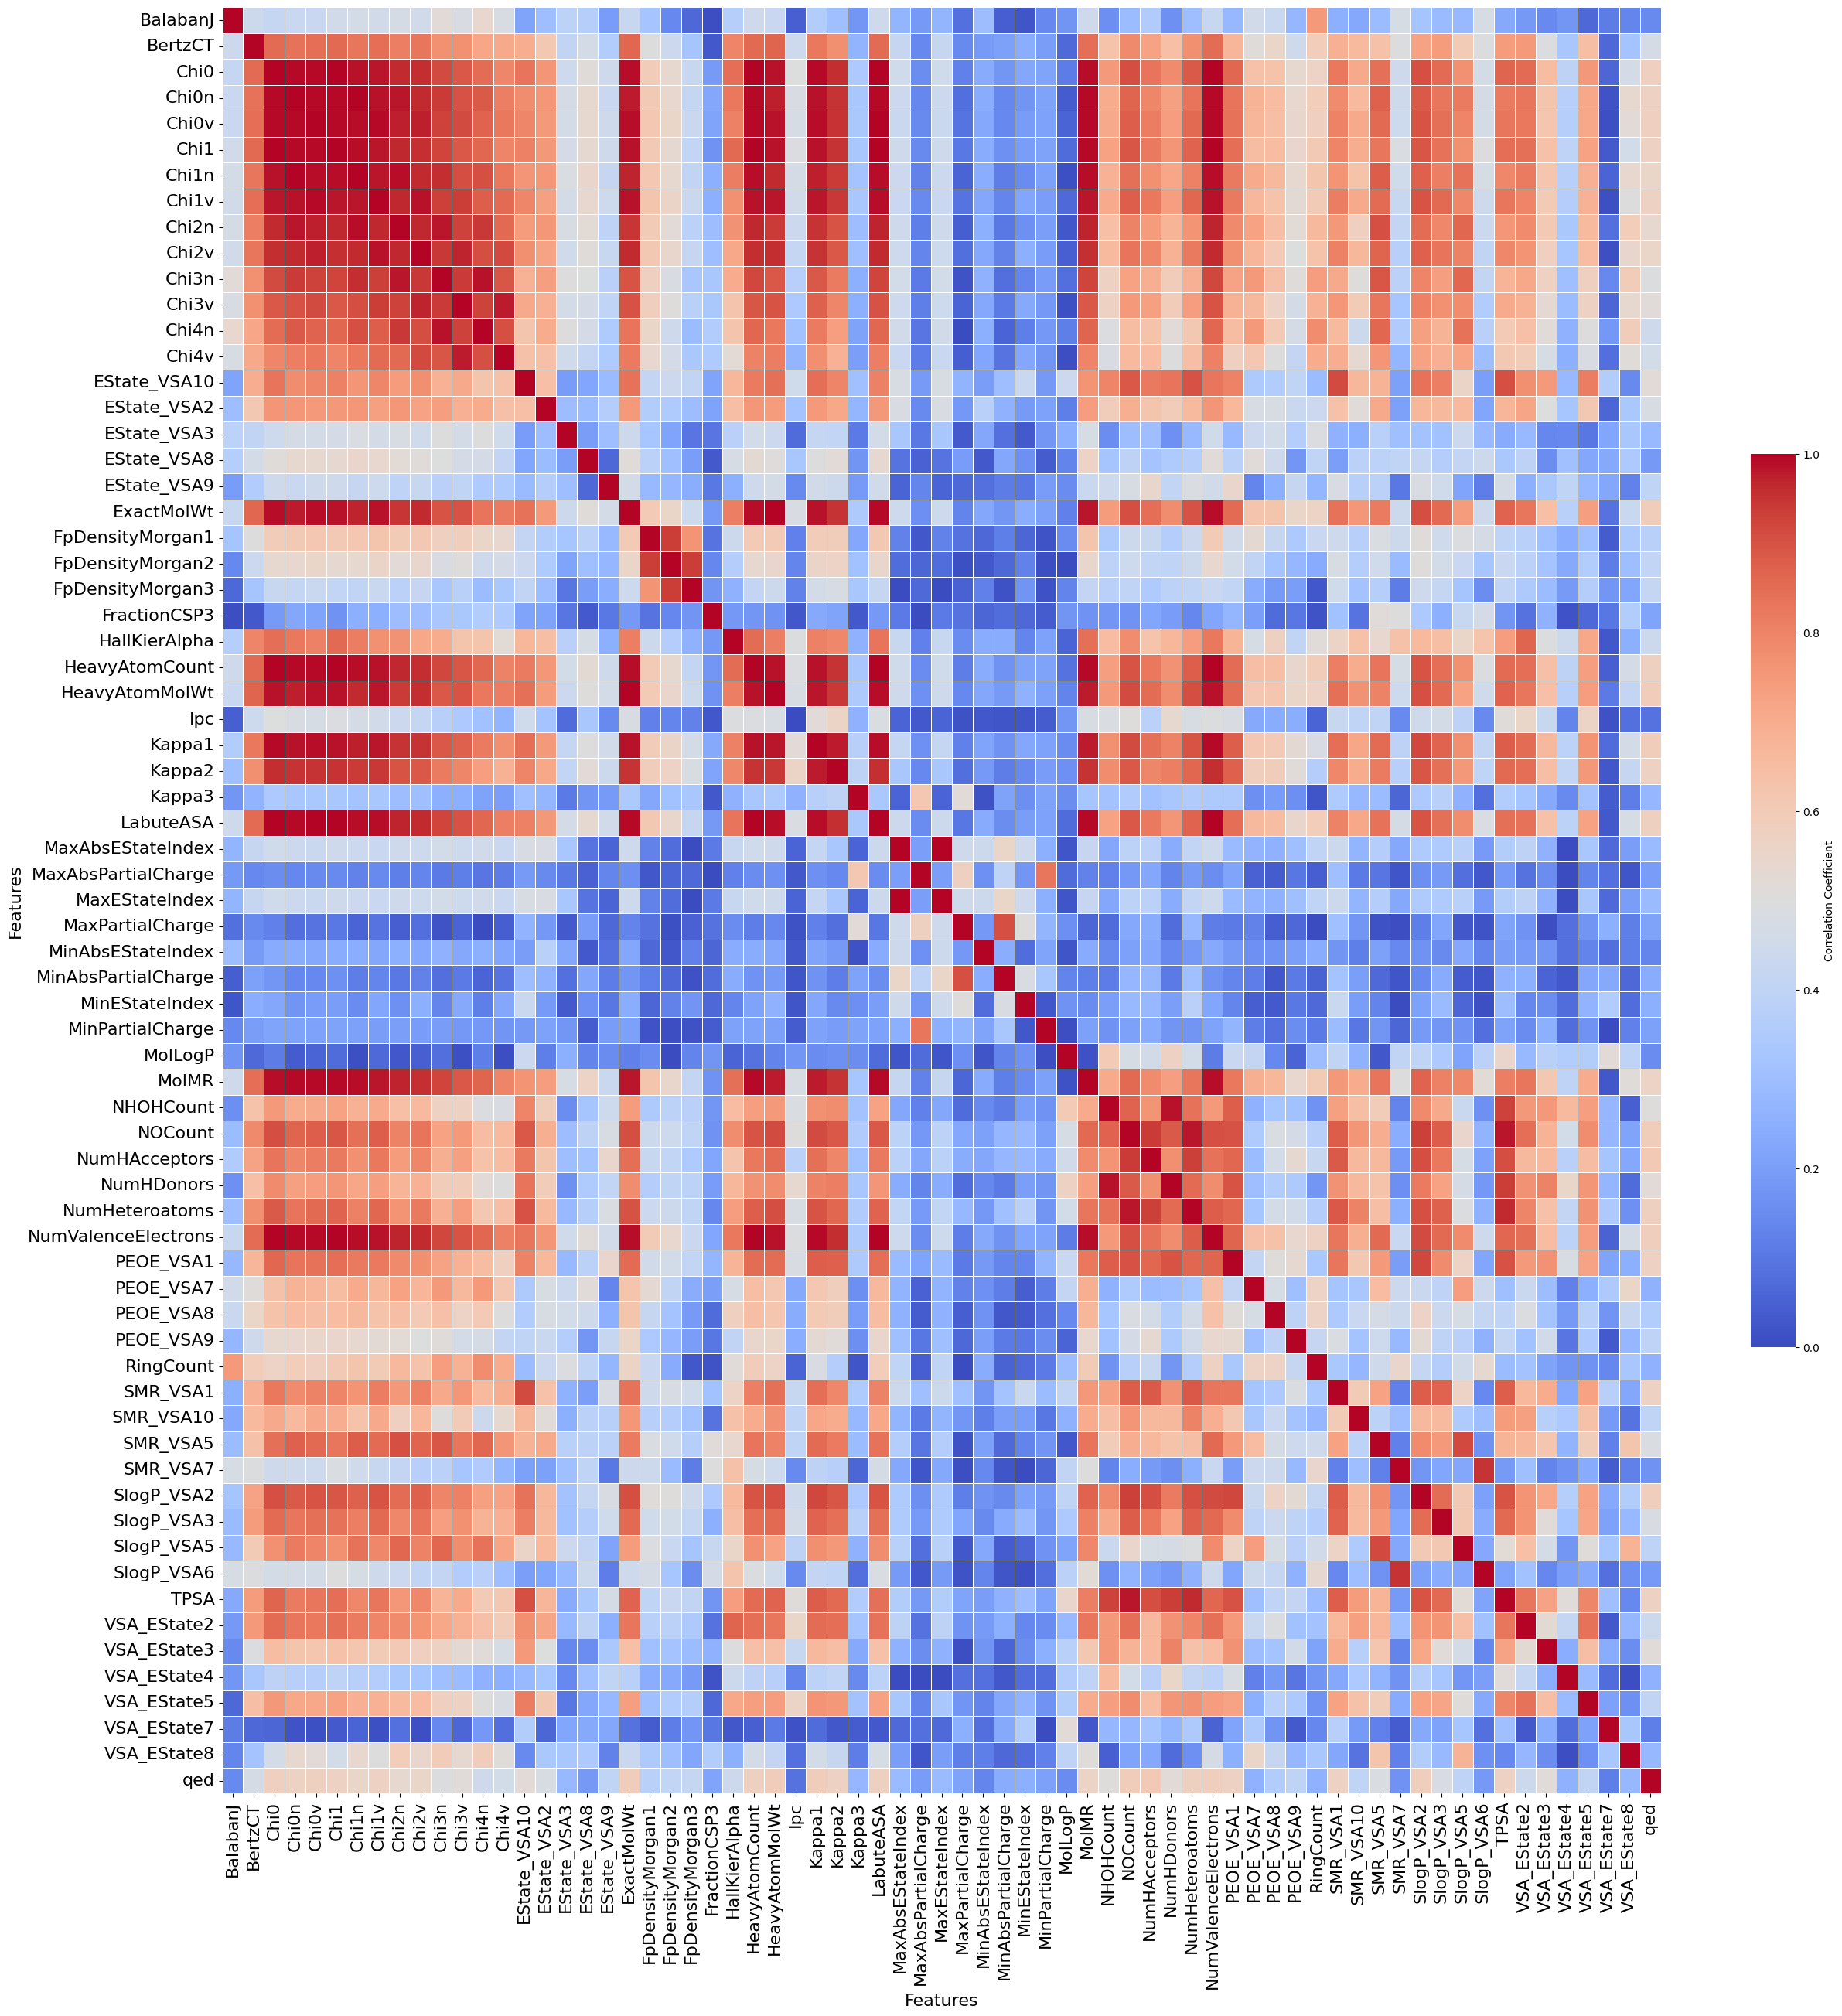

In [ ]:
corr_matrix = descriptors_df_filtered.corr().abs()
plt.figure(figsize=(30, 30))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=.5,
            cbar_kws={'label': 'Correlation Coefficient', 'shrink': 0.5},
            xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16, rotation=0)
plt.xlabel('Features', fontsize=16)
plt.ylabel('Features', fontsize=16)
#plt.title('Correlation Matrix', fontsize=20)
plt.savefig('/content/drive/MyDrive/HOB/Rerun/correlation_matrix.eps', format='eps')
plt.savefig('/content/drive/MyDrive/HOB/Rerun/correlation_matrix.png', format='png')
plt.show()

In [ ]:
descriptors_df_filtered.shape

(721, 69)

In [ ]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than a threshold (e.g., 0.9)
threshold = 0.9
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

# Drop the features
df_reduced = descriptors_df_filtered.drop(columns=to_drop)
df_reduced.shape

print(df_reduced.columns)
with pd.ExcelWriter('/content/drive/MyDrive/HOB/Rerun/intermediate_result.xlsx', engine='openpyxl', mode='a') as writer:
    df_reduced.to_excel(writer, sheet_name='df_reduced', index=False)

Index(['BalabanJ', 'BertzCT', 'Chi0', 'EState_VSA10', 'EState_VSA2',
       'EState_VSA3', 'EState_VSA8', 'EState_VSA9', 'FpDensityMorgan1',
       'FractionCSP3', 'HallKierAlpha', 'Ipc', 'Kappa3', 'MaxAbsEStateIndex',
       'MaxAbsPartialCharge', 'MaxPartialCharge', 'MinAbsEStateIndex',
       'MinEStateIndex', 'MinPartialCharge', 'MolLogP', 'NHOHCount',
       'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'RingCount', 'SMR_VSA10',
       'SMR_VSA7', 'SlogP_VSA3', 'VSA_EState2', 'VSA_EState3', 'VSA_EState4',
       'VSA_EState5', 'VSA_EState7', 'VSA_EState8', 'qed'],
      dtype='object')


In [ ]:
df_reduced.shape

(721, 35)

In [ ]:
merged_df = pd.concat([train_df, df_reduced], axis = 1)
print(merged_df.shape)
#cut_off = 20

# Display the merged DataFrame
with pd.ExcelWriter('/content/drive/MyDrive/HOB/Rerun/intermediate_result.xlsx', engine='openpyxl', mode='a') as writer:
    merged_df.to_excel(writer, sheet_name='merged_data', index=False)

ss_final_df = merged_df[merged_df['Class'] != -1].reset_index(drop=True)
column_to_move = ss_final_df.pop('Class')  # Remove the column and store it
ss_final_df.insert(len(ss_final_df.columns), 'Class', column_to_move)

# Take first and last data and find the average for the oral bioavailability
# Not required now
def average_bioavailability(value):
    if 'to' in value:
        min_value, max_value = map(str, value.split('to'))
        average_value = ((float(min_value) + float(max_value)) / 2)
        return average_value
    else:
        return value

ss_final_df['Oral Bioavailability'] = ss_final_df['Oral Bioavailability'].apply(average_bioavailability)

(721, 45)


In [ ]:
ss_final_df.shape

(698, 45)

<ipython-input-22-f7c8a06a073f>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Bioavailability Range', y='Count', data=plot_data, palette=colors, hue=None, legend=False)


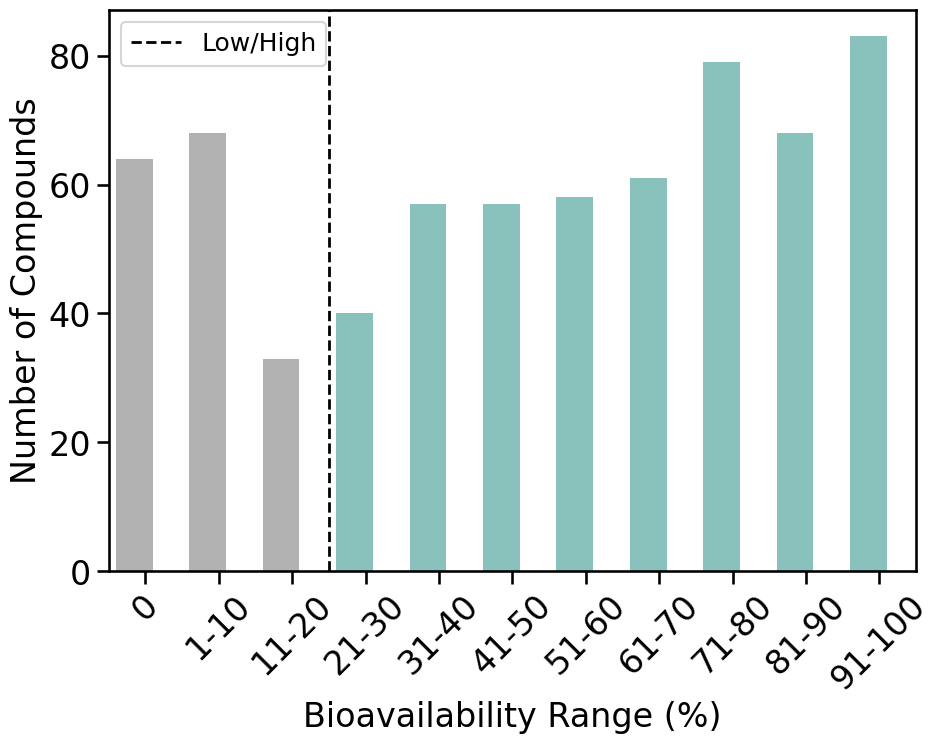

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the 'Oral Bioavailability' column to numeric, coercing errors to NaN
ss_final_df['Oral Bioavailability'] = pd.to_numeric(ss_final_df['Oral Bioavailability'], errors='coerce')

# Handle NaN values - fill them with 0
ss_final_df['Oral Bioavailability'] = ss_final_df['Oral Bioavailability'].fillna(0)

# Define bioavailability ranges
bins = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0', '1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']

# Create a new column for the bioavailability ranges
ss_final_df['Bioavailability Range'] = pd.cut(ss_final_df['Oral Bioavailability'], bins=bins, labels=labels, right=False)

# Count the number of compounds in each range
range_counts = ss_final_df['Bioavailability Range'].value_counts().sort_index()

# Prepare the data for plotting
plot_data = pd.DataFrame({'Bioavailability Range': range_counts.index, 'Count': range_counts.values})

# Define custom colors for low and high ranges
colors = ['#B2B2B2'] * 3 + ['#80CBC4'] * (len(plot_data) - 3)  # Light gray for low, teal green for high

# Set the context to increase font size
sns.set_context("talk", font_scale=1.4)  # "talk" context with larger font scale

# Plot the distribution
plt.figure(figsize=(10, 8))  # Reduce width of the plot
ax = sns.barplot(x='Bioavailability Range', y='Count', data=plot_data, palette=colors, hue=None, legend=False)

# Add a vertical line to distinguish low and high ranges
# Find the index corresponding to the 20% range
threshold_index = plot_data[plot_data['Bioavailability Range'] == '21-30'].index[0]
ax.axvline(x=threshold_index - 0.5, color='black', linestyle='--', linewidth=2, label='Low/High')

# Adjust the bar width
for patch in ax.patches:
    # Reduce the width of each bar (default is 0.8, adjust as needed)
    patch.set_width(0.5)

plt.xlabel('Bioavailability Range (%)', fontsize=24)
plt.ylabel('Number of Compounds', fontsize=24)
plt.xticks(rotation=45, fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=18)
plt.tight_layout()

plt.savefig('/content/drive/MyDrive/HOB/Rerun/distribution_bio.eps', format='eps')
plt.savefig('/content/drive/MyDrive/HOB/Rerun/distribution_bio.png', format='png')
plt.show()


In [ ]:

#input_df['Class'] = pd.to_numeric(input_df['Oral Bioavailability'], errors='coerce').apply(lambda x: 'high' if x > cut_off else 'low')
ss_final_df.drop('Oral Bioavailability', axis=1, inplace=True)
ss_final_df.drop('Pharmacological Class', axis=1, inplace=True)
ss_final_df.drop('Bioavailability Range', axis=1, inplace=True)
#merged_df.drop('MolMR', axis=1, inplace=True)


with pd.ExcelWriter('/content/drive/MyDrive/HOB/Rerun/intermediate_result.xlsx', engine='openpyxl', mode='a') as writer:
    ss_final_df.to_excel(writer, sheet_name='ss_final_data', index=False)

final_df = ss_final_df.copy()

final_df.drop('Structure (SMILES)', axis=1, inplace=True)
with pd.ExcelWriter('/content/drive/MyDrive/HOB/Rerun/intermediate_result.xlsx', engine='openpyxl', mode='a') as writer:
    final_df.to_excel(writer, sheet_name='final_data', index=False)

separated_df = merged_df[merged_df['Class'] == -1].reset_index(drop=True)
column_to_move = separated_df.pop('Class')  # Remove the column and store it
separated_df.insert(len(separated_df.columns), 'Class', column_to_move)

# Display the merged DataFrame
with pd.ExcelWriter('/content/drive/MyDrive/HOB/Rerun/intermediate_result.xlsx', engine='openpyxl', mode='a') as writer:
    separated_df.to_excel(writer, sheet_name='separated_data', index=False)

print(final_df.shape)

(698, 42)


In [ ]:
selected_descriptors = df_reduced.columns
test_smiles_string = test_df["Structure (SMILES)"]

test_data = [compute_topological_features(smiles, selected_descriptors) for smiles in test_smiles_string]
test_descriptors_df = pd.DataFrame(test_data, columns = selected_descriptors)

with pd.ExcelWriter('/content/drive/MyDrive/HOB/Rerun/intermediate_result.xlsx', engine='openpyxl', mode='a') as writer:
    test_descriptors_df.to_excel(writer, sheet_name='test_descriptors', index=False)

test_merged_df = pd.concat([test_df, test_descriptors_df], axis = 1)
print(test_merged_df.shape)

with pd.ExcelWriter('/content/drive/MyDrive/HOB/Rerun/intermediate_result.xlsx', engine='openpyxl', mode='a') as writer:
    test_merged_df.to_excel(writer, sheet_name='test_merged_data', index=False)

test_merged_df.drop('Structure (SMILES)', axis=1, inplace=True)
test_merged_df.drop('Oral Bioavailability', axis =1, inplace =True)
test_merged_df.drop('Pharmacological Class', axis=1, inplace=True)
column_to_move = test_merged_df.pop('Class')  # Remove the column and store it
test_merged_df.insert(len(test_merged_df.columns), 'Class', column_to_move)

with pd.ExcelWriter('/content/drive/MyDrive/HOB/Rerun/intermediate_result.xlsx', engine='openpyxl', mode='a') as writer:
    test_merged_df.to_excel(writer, sheet_name='test_final_data', index=False)


[12:29:50] DEPRECATION WARNING: please use MorganGenerator
[12:29:50] DEPRECATION WARNING: please use MorganGenerator
[12:29:50] DEPRECATION WARNING: please use MorganGenerator
[12:29:50] DEPRECATION WARNING: please use MorganGenerator
[12:29:50] DEPRECATION WARNING: please use MorganGenerator
[12:29:50] DEPRECATION WARNING: please use MorganGenerator
[12:29:50] DEPRECATION WARNING: please use MorganGenerator
[12:29:51] DEPRECATION WARNING: please use MorganGenerator
[12:29:51] DEPRECATION WARNING: please use MorganGenerator
[12:29:51] DEPRECATION WARNING: please use MorganGenerator
[12:29:51] DEPRECATION WARNING: please use MorganGenerator
[12:29:51] DEPRECATION WARNING: please use MorganGenerator
[12:29:51] DEPRECATION WARNING: please use MorganGenerator
[12:29:51] DEPRECATION WARNING: please use MorganGenerator
[12:29:51] DEPRECATION WARNING: please use MorganGenerator
[12:29:51] DEPRECATION WARNING: please use MorganGenerator
[12:29:51] DEPRECATION WARNING: please use MorganGenerat

(45, 45)


In [ ]:
train_smiles = ss_final_df['Structure (SMILES)']
#test_smiles_string
def tanimoto_coefficient(fp1, fp2):
    return DataStructs.TanimotoSimilarity(fp1, fp2)
train_fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 2) for smiles in train_smiles]
test_fps_1 = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 2) for smiles in test_smiles_string]
def max_tanimoto_similarity(test_fps, train_fps):
    similarities = []
    for test_fp in test_fps:
        max_similarity = max(tanimoto_coefficient(test_fp, train_fp) for train_fp in train_fps)
        similarities.append(max_similarity)
    return similarities

# Compute similarities
similarities_test_1 = max_tanimoto_similarity(test_fps_1, train_fps)

average_similarity_test_1 = np.mean(similarities_test_1)


[12:30:24] DEPRECATION WARNING: please use MorganGenerator
[12:30:24] DEPRECATION WARNING: please use MorganGenerator
[12:30:24] DEPRECATION WARNING: please use MorganGenerator
[12:30:24] DEPRECATION WARNING: please use MorganGenerator
[12:30:24] DEPRECATION WARNING: please use MorganGenerator
[12:30:24] DEPRECATION WARNING: please use MorganGenerator
[12:30:24] DEPRECATION WARNING: please use MorganGenerator
[12:30:24] DEPRECATION WARNING: please use MorganGenerator
[12:30:24] DEPRECATION WARNING: please use MorganGenerator
[12:30:24] DEPRECATION WARNING: please use MorganGenerator
[12:30:24] DEPRECATION WARNING: please use MorganGenerator
[12:30:24] DEPRECATION WARNING: please use MorganGenerator
[12:30:24] DEPRECATION WARNING: please use MorganGenerator
[12:30:24] DEPRECATION WARNING: please use MorganGenerator
[12:30:24] DEPRECATION WARNING: please use MorganGenerator
[12:30:24] DEPRECATION WARNING: please use MorganGenerator
[12:30:24] DEPRECATION WARNING: please use MorganGenerat

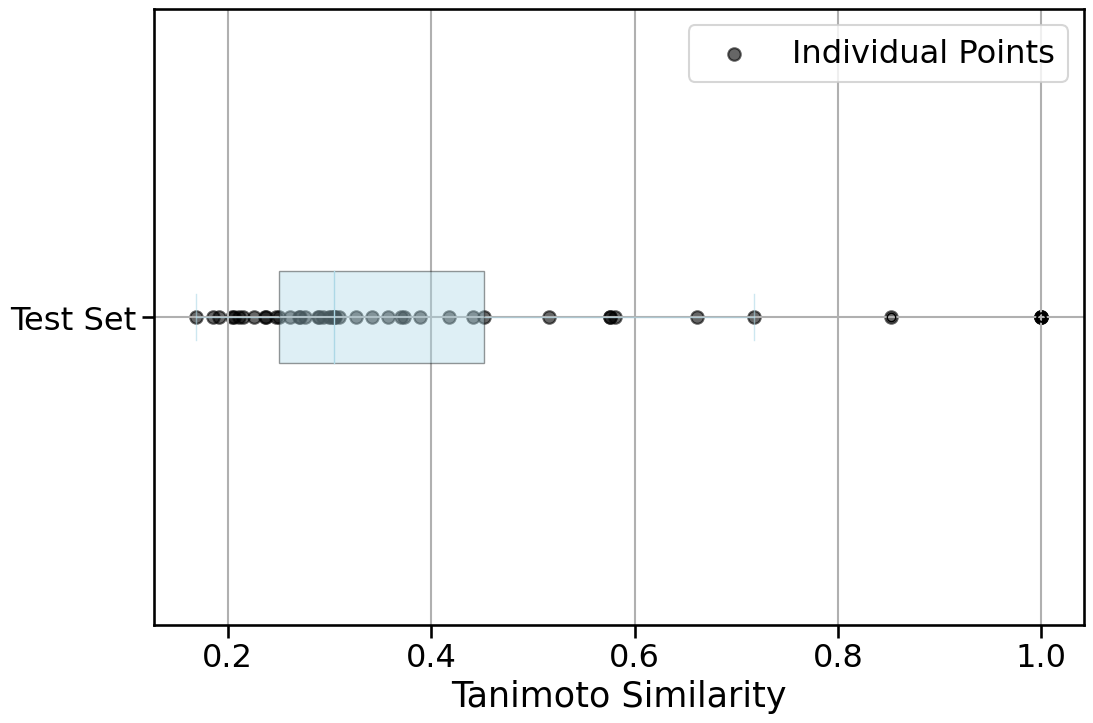

In [ ]:
# Data for box plot
data = [similarities_test_1]
labels = ['Test Set']

# Create box plot with lighter, more transparent boxes
plt.figure(figsize=(12, 8))
box = plt.boxplot(data, labels=labels, vert=False, patch_artist=True,
                  boxprops=dict(facecolor='lightblue', alpha=0.4),  # Lighter blue with transparency
                  whiskerprops=dict(color='lightblue', alpha=0.6),  # Lighter whisker color with transparency
                  capprops=dict(color='lightblue', alpha=0.6),      # Lighter cap color with transparency
                  medianprops=dict(color='lightblue'))              # Lighter median line color

# Overlay individual points
for i, points in enumerate(data):
    plt.scatter(points, [i + 1] * len(points), color='black', alpha=0.6, label='Individual Points' if i == 0 else "")

# Add horizontal lines and labels
plt.xlabel('Tanimoto Similarity')
#plt.title('Distribution of Tanimoto Similarity Scores')
plt.grid(True)

# Add legend
plt.legend(loc='best')

# Save as PDF first
plt.savefig('/content/drive/MyDrive/HOB/Rerun/tanimoto.png', format='png')
plt.savefig('/content/drive/MyDrive/HOB/Rerun/tanimoto.eps', format='eps')

plt.show()

In [ ]:
# dataset preprocessing
from sklearn.preprocessing import RobustScaler

def remove_lower_var_col(data, var_thresh):
    drug_names = data.iloc[:, 0]
    X = data.iloc[:, 1:-1]
    y = data.iloc[:, -1]
    selector = VarianceThreshold(var_thresh)
    X.replace([np.inf, -np.inf], np.finfo(np.float64).max, inplace=True)
    X_selected = selector.fit_transform(X)
    selected_indices = selector.get_support(indices=True)
    selected_features = X.columns[selected_indices]
    selected_df = pd.DataFrame(X_selected, columns=selected_features)
    selected_df.insert(0, 'Drug Name', drug_names)
    selected_df['Class'] = y
    return selected_df

#selected_df = remove_lower_var_col(final_df, 0.001)
#print(selected_df.shape)
#with pd.ExcelWriter('D:\Dataset_koyel\intermediate_result.xlsx', engine='openpyxl', mode='a') as writer:
 #   selected_df.to_excel(writer, sheet_name='var_removed', index=False)


def preprocess_classification(X):
    X.replace([np.inf, -np.inf], np.finfo(np.float64).max, inplace=True)
    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)
    scaler = MinMaxScaler()
    #scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X_imputed)
    return X_scaled

train_pre = preprocess_classification(final_df.iloc[:, 1:-1])
with pd.ExcelWriter('/content/drive/MyDrive/HOB/Rerun/intermediate_result.xlsx', engine='openpyxl', mode='a') as writer:
    pd.DataFrame(train_pre).to_excel(writer, sheet_name='input_classifier', index=False)

print(train_pre.shape)

(698, 40)


In [ ]:
test_pre = preprocess_classification(test_merged_df.iloc[:, 1:-1])
with pd.ExcelWriter('/content/drive/MyDrive/HOB/Rerun/intermediate_result.xlsx', engine='openpyxl', mode='a') as writer:
    pd.DataFrame(test_pre).to_excel(writer, sheet_name='test_classifier', index=False)

print(test_pre.shape)

(45, 40)


In [ ]:
print("the final data size", train_pre.shape)
y_binary = final_df['Class']
class_distribution = final_df['Class'].value_counts()
print(class_distribution)

the final data size (698, 40)
Class
1    535
0    163
Name: count, dtype: int64


In [ ]:
final_df.shape

(698, 42)

In [ ]:
print("the final data size", test_pre.shape)
yt_binary = test_merged_df['Class']
class_distribution = test_merged_df['Class'].value_counts()
print(class_distribution)

the final data size (45, 40)
Class
1    28
0    17
Name: count, dtype: int64


In [ ]:
import re
import xml.etree.ElementTree as ET
import pandas as pd
from chembl_webresource_client.new_client import new_client
import pubchempy as pcp

# Initialize ChEMBL client
molecule = new_client.molecule

# Function to normalize drug names by removing special characters
def normalize_drug_name(name):
    return re.sub(r'[^a-zA-Z0-9]', '', name).lower()

# Function to parse DrugBank XML file and extract necessary information
def parse_drugbank_xml(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()

    drug_data = []

    for drug in root.findall("{http://www.drugbank.ca}drug"):
        drug_name = drug.find("{http://www.drugbank.ca}name").text
        normalized_name = normalize_drug_name(drug_name)

        calculated_properties = drug.find("{http://www.drugbank.ca}calculated-properties")
        atc_codes = drug.find("{http://www.drugbank.ca}atc-codes")

        smiles_text = None
        atc_codes_list = []

        if calculated_properties is not None:
            for property in calculated_properties.findall("{http://www.drugbank.ca}property"):
                kind = property.find("{http://www.drugbank.ca}kind").text
                if kind == "SMILES":
                    smiles_text = property.find("{http://www.drugbank.ca}value").text
                    break

        if atc_codes is not None:
            for atc_code in atc_codes.findall("{http://www.drugbank.ca}atc-code"):
                atc_codes_list.append(atc_code.get("code"))

        drug_data.append({
            "Drug_Name": drug_name,
            "Normalized_Name": normalized_name,
            "SMILES": smiles_text,
            "ATC_Codes": atc_codes_list if atc_codes_list else None
        })

    return pd.DataFrame(drug_data)

# Load DrugBank data from XML file
drugbank_df = parse_drugbank_xml(r'C:\Users\Prof.Ashish Ghosh\Desktop\Dataset\Drug\full database.xml')

# Example list of drug names with possible variations
drug_names = test_df['Drug Name']

# Function to get SMILES from DrugBank using normalized drug name
def get_smiles_from_drugbank(drug_name):
    normalized_name = normalize_drug_name(drug_name)
    try:
        row = drugbank_df.loc[drugbank_df['Normalized_Name'] == normalized_name]
        if not row.empty and pd.notna(row.iloc[0]['SMILES']):
            return row.iloc[0]['SMILES']
        else:
            print(f"No SMILES found for {drug_name} in DrugBank")
            return None
    except Exception as e:
        print(f"Error retrieving SMILES for {drug_name} from DrugBank: {e}")
        return None

# Function to get ATC codes from DrugBank using normalized drug name
def get_atc_code_from_drugbank(drug_name):
    normalized_name = normalize_drug_name(drug_name)
    try:
        row = drugbank_df.loc[drugbank_df['Normalized_Name'] == normalized_name]
        if not row.empty and pd.notna(row.iloc[0]['ATC_Codes']):
            return row.iloc[0]['ATC_Codes']
        else:
            print(f"No ATC codes found for {drug_name} in DrugBank")
            return None
    except Exception as e:
        print(f"Error retrieving ATC codes for {drug_name} from DrugBank: {e}")
        return None

# Function to get SMILES from PubChem using drug name
def get_smiles_from_pubchem(drug_name):
    try:
        compounds = pcp.get_compounds(drug_name, 'name')
        if compounds:
            return compounds[0].canonical_smiles
        else:
            print(f"No SMILES found for {drug_name} in PubChem")
            return None
    except Exception as e:
        print(f"Error retrieving SMILES for {drug_name} from PubChem: {e}")
        return None

# Function to get SMILES from ChEMBL using drug name
def get_smiles_from_chembl(drug_name):
    try:
        res = molecule.filter(pref_name__iexact=drug_name).only(['molecule_structures'])
        if res and res[0]['molecule_structures']:
            return res[0]['molecule_structures']['canonical_smiles']
        else:
            print(f"No SMILES found for {drug_name} in ChEMBL")
            return None
    except Exception as e:
        print(f"Error retrieving SMILES for {drug_name} from ChEMBL: {e}")
        return None

# Function to get ATC codes from ChEMBL using drug name
def get_atc_code_from_chembl(drug_name):
    try:
        res = molecule.filter(pref_name__iexact=drug_name).only(['atc_classifications'])
        if res and res[0]['atc_classifications']:
            return res[0]['atc_classifications']
        else:
            print(f"No ATC codes found for {drug_name} in ChEMBL")
            return None
    except Exception as e:
        print(f"Error retrieving ATC codes for {drug_name} from ChEMBL: {e}")
        return None

# Create a DataFrame to store results
results = []

# Function to handle variations in drug names
def get_drug_info(drug_name_variations):
    for name in drug_name_variations:
        # Check DrugBank
        smiles = get_smiles_from_drugbank(name)
        if smiles:
            atc_codes = get_atc_code_from_drugbank(name)
            return {'Drug_Name': name, 'SMILES': smiles, 'ATC_Codes': atc_codes}

        # Check PubChem
        smiles = get_smiles_from_pubchem(name)
        if smiles:
            atc_codes = get_atc_code_from_chembl(name)  # PubChem does not provide ATC codes
            return {'Drug_Name': name, 'SMILES': smiles, 'ATC_Codes': atc_codes}

        # Check ChEMBL
        smiles = get_smiles_from_chembl(name)
        if smiles:
            atc_codes = get_atc_code_from_chembl(name)
            return {'Drug_Name': name, 'SMILES': smiles, 'ATC_Codes': atc_codes}

    return {'Drug_Name': drug_name_variations[0], 'SMILES': None, 'ATC_Codes': None}

for drug_name in drug_names:
    variations = [drug_name, normalize_drug_name(drug_name)]
    results.append(get_drug_info(variations))

df_results = pd.DataFrame(results)

# Save results to CSV file
df_results.to_csv(r'D:\Dataset_koyel\test_drug_smiles_atc_combined.csv', index=False)

# Display the results
print(df_results)


In [ ]:
# ATC code frequency matrix

atc_train = pd.read_excel('/content/drive/MyDrive/HOB/drug_atc.xlsx', sheet_name='train_final')
atc_test = pd.read_excel('/content/drive/MyDrive/HOB/drug_atc.xlsx', sheet_name='test')
#print(atc_train.columns)
#print(atc_test.columns)

atc_train_filled = atc_train[['Drug Name', 'ATC_Codes']].fillna('0').apply(lambda x: x.str.strip() if x.dtype == "object" else x)
atc_test_filled = atc_test[['Drug Name', 'ATC_Codes']].fillna('0').apply(lambda x: x.str.strip() if x.dtype == "object" else x)

atc_codes = pd.concat([atc_train_filled, atc_test_filled], axis=0).reset_index(drop=True)
#atc_codes = atc_codes.to_frame(name='ATC_Codes')

In [ ]:
# Function to split ATC codes
def split_atc_codes(atc_codes):
    if atc_codes == '0':
        return ['0']
    atc_codes = atc_codes.strip()
    parts = []
    for code in atc_codes.split(', '):
        code = code.strip()
        if len(code) >= 1:
            parts.append(code[0])  # Single char
        if len(code) >= 3:
            parts.append(code[:3])  # Single char and two digits
        if len(code) >= 4:
            parts.append(code[:4])  # Single char, two digits, single char
        if len(code) >= 5:
            parts.append(code[:5])  # Single char, two digits, two chars
        parts.append(code)  # Entire string
    return parts

# Apply split function and get unique ATC code parts
all_atc_parts = atc_codes['ATC_Codes'].apply(split_atc_codes)
unique_atc_parts = set(part for sublist in all_atc_parts for part in sublist)
unique_atc_parts = sorted(unique_atc_parts)

unique_atc_parts = [code for code in unique_atc_parts if code != '0']
#unique_atc_parts

atc_matrix_train = pd.DataFrame(0, index = atc_train['Drug Name'], columns = unique_atc_parts)
atc_matrix_test = pd.DataFrame(0, index = atc_test['Drug Name'], columns = unique_atc_parts)

In [ ]:
# Assuming atc_test_filled is a DataFrame or converting if it's not
atc_matrix_train = pd.DataFrame(0, index=atc_train['Drug Name'], columns=unique_atc_parts)

# Assuming atc_train_filled is a DataFrame or converting if it's not
if not isinstance(atc_train_filled, pd.DataFrame):
    atc_train_filled = pd.DataFrame(atc_train_filled)

# Now iterate over rows in the DataFrame
for i, row in atc_train_filled.iterrows():
    atc_codes = split_atc_codes(row['ATC_Codes'])
   # print(atc_codes)
    for code in atc_codes:
        if code in unique_atc_parts:
            atc_matrix_train.at[row['Drug Name'], code] += 1

# Fill NaN or missing values with 0
atc_matrix_train.fillna(0, inplace=True)

# Display the resulting matrix
#print(atc_matrix_train)
print(atc_matrix_train.shape)

(698, 2088)


In [ ]:
import pandas as pd

atc_matrix_test = pd.DataFrame(0, index=atc_test['Drug Name'], columns=unique_atc_parts)

# Assuming atc_test_filled is a DataFrame or converting if it's not
if not isinstance(atc_test_filled, pd.DataFrame):
    atc_test_filled = pd.DataFrame(atc_test_filled)

# Now iterate over rows in the DataFrame
for i, row in atc_test_filled.iterrows():
    atc_codes = split_atc_codes(row['ATC_Codes'])
    #print(atc_codes)
    for code in atc_codes:
        if code in unique_atc_parts:
            atc_matrix_test.at[row['Drug Name'], code] += 1

# Fill NaN or missing values with 0
atc_matrix_test.fillna(0, inplace=True)

# Display the resulting matrix
#print(atc_matrix_test)
print(atc_matrix_test.shape)

(45, 2088)


In [ ]:
def preprocess_classification_atc(X):
    X_imputed = imputer.fit_transform(X)
    scaler = MinMaxScaler()
    #scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X_imputed)
    return X_scaled

train_atc_norm = preprocess_classification(atc_matrix_train.iloc[:, 0:])
test_atc_norm = preprocess_classification(atc_matrix_test.iloc[:, 0:])
#with pd.ExcelWriter(r'D:\Dataset_koyel\intermediate_result.xlsx', engine='openpyxl', mode='a') as writer:
#    pd.DataFrame(train_pre).to_excel(writer, sheet_name='input_classifier', index=False)

print(train_atc_norm.shape)
print(test_atc_norm.shape)

(698, 2088)
(45, 2088)


In [ ]:
pd.DataFrame(train_atc_norm).to_csv('/content/drive/MyDrive/HOB/Rerun/train_atc_norm.csv', index=False)
pd.DataFrame(test_atc_norm).to_csv('/content/drive/MyDrive/HOB/Rerun/test_atc_norm.csv', index=False)

In [ ]:
train_merged_array = np.concatenate((train_pre, train_atc_norm), axis=1)
test_merged_array = np.concatenate((test_pre, test_atc_norm), axis=1)

In [ ]:
test_pre.shape

(45, 40)

In [ ]:
pd.DataFrame(train_merged_array).to_csv('/content/drive/MyDrive/HOB/Rerun/train_merged_array.csv', index=False)
pd.DataFrame(test_merged_array).to_csv('/content/drive/MyDrive/HOB/Rerun/test_merged_array.csv', index=False)

Parameter tuning for combined

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Declare the classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Naive Bayes": GaussianNB(),
    "AdaBoost Classifier": AdaBoostClassifier(algorithm = "SAMME"),
    "Extreme Gradient Boosting": xgb.XGBClassifier(random_state=1),
    "CatBoost Classifier": CatBoostClassifier(verbose=0)
}

# Set the parameters
param_grids = {
    "Random Forest": {
        'n_estimators': np.linspace(100, 500, num=5, dtype=int),  # Number of trees
        'min_samples_leaf': np.linspace(1, 20, num=5, dtype=int)  # Minimum samples per leaf
    },
    "Support Vector Machine": {
        "C": np.geomspace(0.03125, 32768, num=5),  # Regularization parameter
        'gamma': np.geomspace(0.00003051757, 16, num=5),  # Kernel coefficient
        'kernel': ['rbf', 'linear', 'poly', 'sigmoid']  # Kernel type
    },
    "K-Nearest Neighbors": {
        "n_neighbors": np.linspace(3, 30, num=5, dtype=int)  # Number of neighbors
    },
    "Decision Tree Classifier": {
        "max_depth": np.linspace(10, 40, num=5, dtype=int),  # Maximum tree depth
        "min_samples_split": np.linspace(2, 20, num=5, dtype=int),  # Minimum samples per split
        "min_samples_leaf": np.linspace(1, 20, num=5, dtype=int)  # Minimum samples per leaf
    },
    "Logistic Regression": {
        "C": np.linspace(0.1, 10, num=5),  # Regularization parameter
        "solver": ['liblinear', 'saga']  # Solver algorithm
    },
    "Gradient Boosting": {
        'n_estimators': np.linspace(40, 70, num=5, dtype=int),  # Number of boosting stages
        'learning_rate': np.linspace(0.05, 0.2, num=5),  # Learning rate
        'max_depth': np.linspace(4, 8, num=5, dtype=int)  # Maximum tree depth
    },
    "Naive Bayes": {},  # No parameters to tune for GaussianNB
    "AdaBoost Classifier": {
        'n_estimators': np.linspace(50, 300, num=5, dtype=int),  # Number of boosting stages
        'learning_rate': np.linspace(0.01, 1.0, num=5)  # Learning rate
    },
    "Extreme Gradient Boosting": {
        'n_estimators': np.linspace(100, 500, num=5, dtype=int),  # Number of boosting stages
        'learning_rate': np.linspace(0.01, 0.2, num=5),  # Learning rate
        'max_depth': np.linspace(3, 10, num=5, dtype=int),  # Maximum tree depth
        'subsample': np.linspace(0.5, 1.0, num=5),  # Fraction of samples used per tree
        'colsample_bytree': np.linspace(0.5, 1.0, num=5)  # Fraction of features used per tree
    },
    "CatBoost Classifier": {
        'iterations': np.linspace(100, 500, num=5, dtype=int),  # Number of boosting stages
        'learning_rate': np.linspace(0.001, 0.1, num=5),  # Learning rate
        'depth': np.linspace(1, 10, num=5, dtype=int)  # Maximum tree depth
    }
}

best_params_dict = {} # Dictionary to hold the best parameter settings

results = {
    "Classifier": [],
    "Accuracy": [],
    "AUC": [],
    "Balanced Accuracy": [],
    "Recall": [],
    "Precision": [],
    "F1 score" : [],
    "Kappa": []
}

for name, clf in classifiers.items():
    param_grid = param_grids.get(name, {})
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy')
    grid_search.fit(train_merged_array, y_binary)
    #print(grid_search)

    print(f"Results for {name}:")
    cv_results = grid_search.cv_results_
    with open("/content/drive/MyDrive/HOB/Rerun/grid_search_results.txt", "a+") as f:
        f.write(f"The classification algorithm is: {name} \n")
        for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
            f.write(f"Mean accuracy: {mean_score}, Params: {params}\n")

    best_params = grid_search.best_params_
    #print(best_params)
    with open("/content/drive/MyDrive/HOB/Rerun/grid_search_results.txt", "a+") as f:
        f.write("Best Parameters:\n")
        for key, value in best_params.items():
            f.write(f"{key}: {value}\n")

    best_params_dict[name] = best_params
    final_clf = clf.set_params(**best_params)
    #print(final_clf)

    #cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(final_clf, train_merged_array, y_binary, cv=cv, scoring='accuracy')
    #print(scores)

    auc_scores = cross_val_score(final_clf, train_merged_array, y_binary, cv=cv, scoring='roc_auc')

    bacc_scores = cross_val_score(final_clf, train_merged_array, y_binary, cv=cv, scoring='balanced_accuracy')

    recall_scores = cross_val_score(final_clf, train_merged_array, y_binary, cv=cv, scoring='recall')

    precision_scores = cross_val_score(final_clf, train_merged_array, y_binary, cv=cv, scoring='precision')

    f1_scores = cross_val_score(final_clf, train_merged_array, y_binary, cv=cv, scoring='f1')

    kappa_scores = []
    for train_index, test_index in cv.split(train_merged_array, y_binary):
        X_train, X_test = train_merged_array[train_index], train_merged_array[test_index]
        y_train, y_test = y_binary[train_index], y_binary[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        kappa = cohen_kappa_score(y_test, y_pred)
        kappa_scores.append(kappa)

    results["Classifier"].append(name)
    results["Accuracy"].append(scores.mean())
    results["AUC"].append(auc_scores.mean())
    results["Balanced Accuracy"].append(bacc_scores.mean())
    results["Recall"].append(recall_scores.mean())
    results["Precision"].append(precision_scores.mean())
    results["F1 score"].append(f1_scores.mean())
    results["Kappa"].append(np.mean(kappa_scores))


   # tprs = []
   # aucs = []
  #  mean_fpr = np.linspace(0, 1, 100)

  #  fig, ax = plt.subplots()
  #  for i, (train, test) in enumerate(cv.split(train_merged_array, y_binary)):
  #      clf.fit(train_merged_array[train], y_binary[train])
  #      probas_ = final_clf.predict_proba(train_merged_array[test])
  #      fpr, tpr, thresholds = roc_curve(y_binary[test], probas_[:, 1])
  #      tprs.append(np.interp(mean_fpr, fpr, tpr))
  #      tprs[-1][0] = 0.0
   #     roc_auc = auc(fpr, tpr)
  #      aucs.append(roc_auc)
  #      ax.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC fold {i+1} (AUC = {roc_auc:.2f})')

 #   ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
#    mean_tpr = np.mean(tprs, axis=0)
#    mean_tpr[-1] = 1.0
#    mean_auc = auc(mean_fpr, mean_tpr)
 #   std_auc = np.std(aucs)
  #  ax.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f} $\pm$ {std_auc:.2f})', lw=2, alpha=.8)
#    ax.fill_between(mean_fpr, mean_tpr - std_auc, mean_tpr + std_auc, color='gray', alpha=.2)
 #   ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title=f"Receiver Operating Characteristic for {name}")
 #   ax.legend(loc="lower right")
 #   plt.show()

results_df = pd.DataFrame(results)
#results_df

with pd.ExcelWriter('/content/drive/MyDrive/HOB/Rerun/grid_result.xlsx', engine='openpyxl', mode='w') as writer:
    results_df.to_excel(writer, sheet_name='Results_grid', index=False)

best_params_dict
results_df


Results for Random Forest:
Results for Support Vector Machine:
Results for K-Nearest Neighbors:
Results for Decision Tree Classifier:


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which 

Results for Logistic Regression:


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which 

Results for Gradient Boosting:
Results for Naive Bayes:
Results for AdaBoost Classifier:


In [ ]:
best_params_dict

### Evaluation on testing data using CFM after setting the parameters for multiple runs

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, roc_auc_score, balanced_accuracy_score, recall_score,
    precision_score, f1_score, cohen_kappa_score, roc_curve
)
import xgboost as xgb
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import pickle

# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(min_samples_leaf=1, n_estimators=200),
    "Support Vector Machine": SVC(probability=True, C=1024, gamma=3.051757e-05, kernel="rbf"),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=16),
    "Decision Tree Classifier": DecisionTreeClassifier(max_depth=17, min_samples_leaf=1, min_samples_split=20),
    "Logistic Regression": LogisticRegression(C=7.525, solver="liblinear"),
    "Gradient Boosting": GradientBoostingClassifier(learning_rate=0.0875, max_depth=5, n_estimators=47),
    "Naive Bayes": GaussianNB(),
    "AdaBoost Classifier": AdaBoostClassifier(algorithm="SAMME", learning_rate=0.7525, n_estimators=237),
    "Extreme Gradient Boosting": xgb.XGBClassifier(random_state=1, colsample_bytree=0.625, learning_rate=0.105, max_depth=3, n_estimators=300, subsample=0.625),
    "CatBoost Classifier": CatBoostClassifier(verbose=0, depth=5, iterations=400, learning_rate=0.0505)
}

def evaluate_classifiers(train_data, train_labels, test_data, test_labels):
    results = {
        "Classifier": [],
        "Accuracy": [],
        "AUC": [],
        "Balanced Accuracy": [],
        "Recall": [],
        "Precision": [],
        "F1 score": [],
        "Kappa": [],
        "Predicted Classes": []
    }
    roc_data = []

    for name, clf in classifiers.items():
        clf.fit(train_data, train_labels)
        y_pred = clf.predict(test_data)
        y_prob = clf.predict_proba(test_data)[:, 1]

        accuracy = accuracy_score(test_labels, y_pred)
        auc_score = roc_auc_score(test_labels, y_prob)
        balanced_acc = balanced_accuracy_score(test_labels, y_pred)
        recall = recall_score(test_labels, y_pred)
        precision = precision_score(test_labels, y_pred)
        f1 = f1_score(test_labels, y_pred)
        kappa = cohen_kappa_score(test_labels, y_pred)

        results["Classifier"].append(name)
        results["Accuracy"].append(accuracy)
        results["AUC"].append(auc_score)
        results["Balanced Accuracy"].append(balanced_acc)
        results["Recall"].append(recall)
        results["Precision"].append(precision)
        results["F1 score"].append(f1)
        results["Kappa"].append(kappa)
        results["Predicted Classes"].append(y_pred)

        fpr, tpr, _ = roc_curve(test_labels, y_prob)
        roc_data.append((name, fpr, tpr, auc_score))

    return results, roc_data

num_runs = 1
aggregate_results = {
    "Classifier": list(classifiers.keys()),
    "Accuracy": np.zeros(len(classifiers)),
    "AUC": np.zeros(len(classifiers)),
    "Balanced Accuracy": np.zeros(len(classifiers)),
    "Recall": np.zeros(len(classifiers)),
    "Precision": np.zeros(len(classifiers)),
    "F1 score": np.zeros(len(classifiers)),
    "Kappa": np.zeros(len(classifiers)),
}

best_results = {
    "Classifier": list(classifiers.keys()),
    "Best Accuracy": [-1] * len(classifiers),
    "Best AUC": [-1] * len(classifiers),
    "Best Balanced Accuracy": [-1] * len(classifiers),
    "Best Recall": [-1] * len(classifiers),
    "Best Precision": [-1] * len(classifiers),
    "Best F1 score": [-1] * len(classifiers),
    "Best Kappa": [-1] * len(classifiers),
    "Best Predicted Classes": [[] for _ in range(len(classifiers))]
}

# Running the evaluation multiple times
all_roc_data = {name: [] for name in classifiers.keys()}
for run in range(num_runs):
    results, roc_data = evaluate_classifiers(train_merged_array, y_binary, test_merged_array, yt_binary)
    for i, classifier in enumerate(results["Classifier"]):
        # Update aggregate results
        aggregate_results["Accuracy"][i] += results["Accuracy"][i]
        aggregate_results["AUC"][i] += results["AUC"][i]
        aggregate_results["Balanced Accuracy"][i] += results["Balanced Accuracy"][i]
        aggregate_results["Recall"][i] += results["Recall"][i]
        aggregate_results["Precision"][i] += results["Precision"][i]
        aggregate_results["F1 score"][i] += results["F1 score"][i]
        aggregate_results["Kappa"][i] += results["Kappa"][i]

        # Update best results if the current run's accuracy is higher
        if results["Accuracy"][i] > best_results["Best Accuracy"][i]:
            best_results["Best Accuracy"][i] = results["Accuracy"][i]
            best_results["Best AUC"][i] = results["AUC"][i]
            best_results["Best Balanced Accuracy"][i] = results["Balanced Accuracy"][i]
            best_results["Best Recall"][i] = results["Recall"][i]
            best_results["Best Precision"][i] = results["Precision"][i]
            best_results["Best F1 score"][i] = results["F1 score"][i]
            best_results["Best Kappa"][i] = results["Kappa"][i]
            best_results["Best Predicted Classes"][i] = results["Predicted Classes"][i]

        # Append current ROC data for the classifier
        all_roc_data[classifier].append(roc_data[i])

# Calculate the average metrics for aggregate results
for key in aggregate_results.keys():
    if key != "Classifier":
        aggregate_results[key] /= num_runs

# Convert aggregate results and best results to DataFrames
aggregate_results_df = pd.DataFrame(aggregate_results)
best_results_df = pd.DataFrame({
    "Classifier": best_results["Classifier"],
    "Best Accuracy": best_results["Best Accuracy"],
    "Best AUC": best_results["Best AUC"],
    "Best Balanced Accuracy": best_results["Best Balanced Accuracy"],
    "Best Recall": best_results["Best Recall"],
    "Best Precision": best_results["Best Precision"],
    "Best F1 score": best_results["Best F1 score"],
    "Best Kappa": best_results["Best Kappa"]
})

# Save the aggregate and best results to an Excel file
try:
    with pd.ExcelWriter(r'D:\\Dataset_koyel\\intermediate_result.xlsx', engine='openpyxl', mode='a') as writer:
        aggregate_results_df.to_excel(writer, sheet_name='test_roc_cfm_avg', index=False)
        best_results_df.to_excel(writer, sheet_name='test_roc_cfm_best', index=False)
except Exception as e:
    print("Error:", e)

# Save the best predictions to a text file
with open(r'D:\\Dataset_koyel\\test_roc_cfm_best_predictions.txt', 'w') as f:
    for classifier, preds in zip(best_results["Classifier"], best_results["Best Predicted Classes"]):
        f.write(f"Classifier: {classifier}\n")
        f.write("Best Predicted Classes:\n")
        for pred in preds:
            f.write(f"{pred}\n")
        f.write("\n")

# Save the ROC data for later use
with open(r'D:\\Dataset_koyel\\test_roc_cfm.pkl', 'wb') as file:
    pickle.dump(best_results, file)
    pickle.dump(all_roc_data, file)




In [ ]:
best_results_df

In [ ]:
aggregate_results_df

In [ ]:
# Plot ROC curves
plt.figure(figsize=(10, 10))
for name, roc_list in all_roc_data.items():
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)
    for roc in roc_list:
        fpr, tpr, auc_score = roc[1], roc[2], roc[3]
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr /= len(roc_list)
    mean_auc = np.mean([roc[3] for roc in roc_list])
    plt.plot(mean_fpr, mean_tpr, lw=2, label=f'{name} (AUC = {mean_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='r', lw=2, label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=24)
plt.ylabel('True Positive Rate', fontsize=24)
plt.tight_layout()

# Adjust legend position and font size
plt.legend(loc="upper center", fontsize=18, ncol=2, bbox_to_anchor=(0.5, -0.1))
plt.savefig(r'D:\\Dataset_koyel\\test_roc_cfm.eps', format='eps', bbox_inches='tight')
plt.savefig(r'D:\\Dataset_koyel\\test_roc_cfm.png', format='png', bbox_inches='tight')

plt.show()

In [ ]:
# Read from pickle file if required. else ignore
#with open(r'D:\\Dataset_koyel\\all_roc_data.pkl', 'rb') as file:
#    all_roc_data = pickle.load(file)

### Evaluation on testing data using different sampling techniques after setting the parameters multiple runs

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, roc_auc_score, balanced_accuracy_score, recall_score,
    precision_score, f1_score, cohen_kappa_score, roc_curve
)
import xgboost as xgb
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import pickle

# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(min_samples_leaf=1, n_estimators=200),
    "Support Vector Machine": SVC(probability=True, C=1024, gamma=3.051757e-05, kernel="rbf"),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=16),
    "Decision Tree Classifier": DecisionTreeClassifier(max_depth=17, min_samples_leaf=1, min_samples_split=20),
    "Logistic Regression": LogisticRegression(C=7.525, solver="liblinear"),
    "Gradient Boosting": GradientBoostingClassifier(learning_rate=0.0875, max_depth=5, n_estimators=47),
    "Naive Bayes": GaussianNB(),
    "AdaBoost Classifier": AdaBoostClassifier(algorithm="SAMME", learning_rate=0.7525, n_estimators=237),
    "Extreme Gradient Boosting": xgb.XGBClassifier(random_state=1, colsample_bytree=0.625, learning_rate=0.105, max_depth=3, n_estimators=300, subsample=0.625),
    "CatBoost Classifier": CatBoostClassifier(verbose=0, depth=5, iterations=400, learning_rate=0.0505)
}
# Apply Random Oversampling to the training data
#ros = RandomOverSampler(random_state=42)
#X_resampled, y_resampled = ros.fit_resample(train_pre, y_binary)
#X_resampled, y_resampled = ros.fit_resample(train_merged_array, y_binary)

#Random undersampling
#rus = RandomUnderSampler(random_state=42)# fit predictor and target variable not a good option
#X_resampled, y_resampled = rus.fit_resample(train_pre, y_binary)
#X_resampled, y_resampled = rus.fit_resample(train_merged_array, y_binary)

smote = SMOTE(random_state=42)
#X_resampled, y_resampled = smote.fit_resample(train_pre, y_binary)
X_resampled, y_resampled = smote.fit_resample(train_merged_array, y_binary)

# Ensure the resampled data is in DataFrame and Series format
X_resampled = pd.DataFrame(X_resampled)
y_resampled = pd.Series(y_resampled)

def evaluate_classifiers(train_data, train_labels, test_data, test_labels):
    results = {
        "Classifier": [],
        "Accuracy": [],
        "AUC": [],
        "Balanced Accuracy": [],
        "Recall": [],
        "Precision": [],
        "F1 score": [],
        "Kappa": [],
        "Predicted Classes": []
    }
    roc_data = []

    for name, clf in classifiers.items():
        clf.fit(train_data, train_labels)
        y_pred = clf.predict(test_data)
        y_prob = clf.predict_proba(test_data)[:, 1]

        accuracy = accuracy_score(test_labels, y_pred)
        auc_score = roc_auc_score(test_labels, y_prob)
        balanced_acc = balanced_accuracy_score(test_labels, y_pred)
        recall = recall_score(test_labels, y_pred)
        precision = precision_score(test_labels, y_pred)
        f1 = f1_score(test_labels, y_pred)
        kappa = cohen_kappa_score(test_labels, y_pred)

        results["Classifier"].append(name)
        results["Accuracy"].append(accuracy)
        results["AUC"].append(auc_score)
        results["Balanced Accuracy"].append(balanced_acc)
        results["Recall"].append(recall)
        results["Precision"].append(precision)
        results["F1 score"].append(f1)
        results["Kappa"].append(kappa)
        results["Predicted Classes"].append(y_pred)

        fpr, tpr, _ = roc_curve(test_labels, y_prob)
        roc_data.append((name, fpr, tpr, auc_score))

    return results, roc_data

num_runs = 10
aggregate_results = {
    "Classifier": list(classifiers.keys()),
    "Accuracy": np.zeros(len(classifiers)),
    "AUC": np.zeros(len(classifiers)),
    "Balanced Accuracy": np.zeros(len(classifiers)),
    "Recall": np.zeros(len(classifiers)),
    "Precision": np.zeros(len(classifiers)),
    "F1 score": np.zeros(len(classifiers)),
    "Kappa": np.zeros(len(classifiers)),
}

best_results = {
    "Classifier": list(classifiers.keys()),
    "Best Accuracy": [-1] * len(classifiers),
    "Best AUC": [-1] * len(classifiers),
    "Best Balanced Accuracy": [-1] * len(classifiers),
    "Best Recall": [-1] * len(classifiers),
    "Best Precision": [-1] * len(classifiers),
    "Best F1 score": [-1] * len(classifiers),
    "Best Kappa": [-1] * len(classifiers),
    "Best Predicted Classes": [[] for _ in range(len(classifiers))]
}

# Running the evaluation multiple times
all_roc_data = {name: [] for name in classifiers.keys()}
for run in range(num_runs):
    results, roc_data = evaluate_classifiers(X_resampled, y_resampled, test_merged_array, yt_binary)
    for i, classifier in enumerate(results["Classifier"]):
        # Update aggregate results
        aggregate_results["Accuracy"][i] += results["Accuracy"][i]
        aggregate_results["AUC"][i] += results["AUC"][i]
        aggregate_results["Balanced Accuracy"][i] += results["Balanced Accuracy"][i]
        aggregate_results["Recall"][i] += results["Recall"][i]
        aggregate_results["Precision"][i] += results["Precision"][i]
        aggregate_results["F1 score"][i] += results["F1 score"][i]
        aggregate_results["Kappa"][i] += results["Kappa"][i]

        # Update best results if the current run's accuracy is higher
        if results["Accuracy"][i] > best_results["Best Accuracy"][i]:
            best_results["Best Accuracy"][i] = results["Accuracy"][i]
            best_results["Best AUC"][i] = results["AUC"][i]
            best_results["Best Balanced Accuracy"][i] = results["Balanced Accuracy"][i]
            best_results["Best Recall"][i] = results["Recall"][i]
            best_results["Best Precision"][i] = results["Precision"][i]
            best_results["Best F1 score"][i] = results["F1 score"][i]
            best_results["Best Kappa"][i] = results["Kappa"][i]
            best_results["Best Predicted Classes"][i] = results["Predicted Classes"][i]

        # Append current ROC data for the classifier
        all_roc_data[classifier].append(roc_data[i])

# Calculate the average metrics for aggregate results
for key in aggregate_results.keys():
    if key != "Classifier":
        aggregate_results[key] /= num_runs

# Convert aggregate results and best results to DataFrames
aggregate_results_df = pd.DataFrame(aggregate_results)
best_results_df = pd.DataFrame({
    "Classifier": best_results["Classifier"],
    "Best Accuracy": best_results["Best Accuracy"],
    "Best AUC": best_results["Best AUC"],
    "Best Balanced Accuracy": best_results["Best Balanced Accuracy"],
    "Best Recall": best_results["Best Recall"],
    "Best Precision": best_results["Best Precision"],
    "Best F1 score": best_results["Best F1 score"],
    "Best Kappa": best_results["Best Kappa"]
})

# Save the aggregate and best results to an Excel file
try:
    with pd.ExcelWriter(r'D:\\Dataset_koyel\\intermediate_result.xlsx', engine='openpyxl', mode='a') as writer:
        aggregate_results_df.to_excel(writer, sheet_name='test_roc_cfm_avg_smote', index=False)
        best_results_df.to_excel(writer, sheet_name='test_roc_cfm_best_smote', index=False)
except Exception as e:
    print("Error:", e)

# Save the best predictions to a text file
with open(r'D:\\Dataset_koyel\\test_roc_cfm_best_predictions_smote.txt', 'w') as f:
    for classifier, preds in zip(best_results["Classifier"], best_results["Best Predicted Classes"]):
        f.write(f"Classifier: {classifier}\n")
        f.write("Best Predicted Classes:\n")
        for pred in preds:
            f.write(f"{pred}\n")
        f.write("\n")

# Save the ROC data for later use
with open(r'D:\\Dataset_koyel\\test_roc_cfm_.pkl', 'wb') as file:
    pickle.dump(best_results, file)
    pickle.dump(all_roc_data, file)

In [ ]:
# Plot ROC curves
plt.figure(figsize=(10, 10))
for name, roc_list in all_roc_data.items():
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)
    for roc in roc_list:
        fpr, tpr, auc_score = roc[1], roc[2], roc[3]
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr /= len(roc_list)
    mean_auc = np.mean([roc[3] for roc in roc_list])
    plt.plot(mean_fpr, mean_tpr, lw=2, label=f'{name} (AUC = {mean_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='r', lw=2, label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=24)
plt.ylabel('True Positive Rate', fontsize=24)
plt.tight_layout()

# Adjust legend position and font size
plt.legend(loc="upper center", fontsize=18, ncol=2, bbox_to_anchor=(0.5, -0.1))
plt.savefig(r'D:\\Dataset_koyel\\test_roc_cfm_smote.eps', format='eps', bbox_inches='tight')
plt.savefig(r'D:\\Dataset_koyel\\test_roc_cfm_smote.png', format='png', bbox_inches='tight')

plt.show()

#### cross validation CFM


In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.metrics import cohen_kappa_score, roc_curve, auc, accuracy_score, recall_score, precision_score, f1_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import xgboost as xgb
from catboost import CatBoostClassifier
import openpyxl

# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(min_samples_leaf=1, n_estimators=200),
    "Support Vector Machine": SVC(probability=True, C=1024, gamma=3.051757e-05, kernel="rbf"),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=16),
    "Decision Tree Classifier": DecisionTreeClassifier(max_depth=17, min_samples_leaf=1, min_samples_split=20),
    "Logistic Regression": LogisticRegression(C=7.525, solver="liblinear"),
    "Gradient Boosting": GradientBoostingClassifier(learning_rate=0.0875, max_depth=5, n_estimators=47),
    "Naive Bayes": GaussianNB(),
    "AdaBoost Classifier": AdaBoostClassifier(algorithm="SAMME", learning_rate=0.7525, n_estimators=237),
    "Extreme Gradient Boosting": xgb.XGBClassifier(random_state=1, colsample_bytree=0.625, learning_rate=0.105, max_depth=3, n_estimators=300, subsample=0.625),
    "CatBoost Classifier": CatBoostClassifier(verbose=0, depth=5, iterations=400, learning_rate=0.0505)
}
# Initialize results dictionary
results = {
    "Classifier": [],
    "Accuracy": [],
    "AUC": [],
    "Balanced Accuracy": [],
    "Recall": [],
    "Precision": [],
    "F1 score": [],
    "Kappa": []
}

all_roc_data = {name: [] for name in classifiers.keys()}

# Loop through classifiers
for name, clf in classifiers.items():
    cv = RepeatedKFold(n_splits=5, n_repeats=10)
    accuracy_scores = []
    auc_scores = []
    bacc_scores = []
    recall_scores = []
    precision_scores = []
    f1_scores = []
    kappa_scores = []

    for train_index, test_index in cv.split(train_merged_array, y_binary):
        X_train, X_test = train_merged_array[train_index], train_merged_array[test_index]
        y_train, y_test = y_binary[train_index], y_binary[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]

        accuracy_scores.append(accuracy_score(y_test, y_pred))
        auc_scores.append(roc_auc_score(y_test, y_prob))
        bacc_scores.append(balanced_accuracy_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        kappa_scores.append(cohen_kappa_score(y_test, y_pred))

        # ROC Curve data
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        all_roc_data[name].append((fpr, tpr, roc_auc))

    results["Classifier"].append(name)
    results["Accuracy"].append(np.mean(accuracy_scores))
    results["AUC"].append(np.mean(auc_scores))
    results["Balanced Accuracy"].append(np.mean(bacc_scores))
    results["Recall"].append(np.mean(recall_scores))
    results["Precision"].append(np.mean(precision_scores))
    results["F1 score"].append(np.mean(f1_scores))
    results["Kappa"].append(np.mean(kappa_scores))

results_df = pd.DataFrame(results)

# Save results to Excel
try:
    with pd.ExcelWriter(r'D:\Dataset_koyel\intermediate_result.xlsx', engine='openpyxl', mode='a') as writer:
        results_df.to_excel(writer, sheet_name='Cv_cfm', index=False)
except Exception as e:
    print("Error:", e)

# Plot ROC curves
plt.figure(figsize=(10, 10))
for name, roc_list in all_roc_data.items():
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)
    for roc in roc_list:
        fpr, tpr, auc_score = roc[0], roc[1], roc[2]
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr /= len(roc_list)
    mean_auc = np.mean([roc[2] for roc in roc_list])
    plt.plot(mean_fpr, mean_tpr, lw=2, label=f'{name} (AUC = {mean_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='r', lw=2, label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=24)
plt.ylabel('True Positive Rate', fontsize=24)
plt.tight_layout()

# Adjust legend position and font size
plt.legend(loc="upper center", fontsize=18, ncol=2, bbox_to_anchor=(0.5, -0.1))
plt.savefig(r'D:\\Dataset_koyel\\cv_cfm.eps', format='eps', bbox_inches='tight')
plt.savefig(r'D:\\Dataset_koyel\\cv_cfm.png', format='png', bbox_inches='tight')

plt.show()


In [ ]:
# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(min_samples_leaf=1, n_estimators=200),
    "Support Vector Machine": SVC(probability=True, C=1024, gamma=3.051757e-05, kernel="rbf"),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=16),
    "Decision Tree Classifier": DecisionTreeClassifier(max_depth=17, min_samples_leaf=1, min_samples_split=20),
    "Logistic Regression": LogisticRegression(C=7.525, solver="liblinear"),
    "Gradient Boosting": GradientBoostingClassifier(learning_rate=0.0875, max_depth=5, n_estimators=47),
    "Naive Bayes": GaussianNB(),
    "AdaBoost Classifier": AdaBoostClassifier(algorithm="SAMME", learning_rate=0.7525, n_estimators=237),
    "Extreme Gradient Boosting": xgb.XGBClassifier(random_state=1, colsample_bytree=0.625, learning_rate=0.105, max_depth=3, n_estimators=300, subsample=0.625),
    "CatBoost Classifier": CatBoostClassifier(verbose=0, depth=5, iterations=400, learning_rate=0.0505)
}

# Initialize results dictionary
results = {
    "Classifier": [],
    "Accuracy": [],
    "AUC": [],
    "Balanced Accuracy": [],
    "Recall": [],
    "Precision": [],
    "F1 score": [],
    "Kappa": []
}

all_roc_data = {name: [] for name in classifiers.keys()}

# Loop through classifiers
for name, clf in classifiers.items():
    cv = RepeatedKFold(n_splits=5, n_repeats=10)
    accuracy_scores = []
    auc_scores = []
    bacc_scores = []
    recall_scores = []
    precision_scores = []
    f1_scores = []
    kappa_scores = []

    for train_index, test_index in cv.split(train_merged_array, y_binary):
        X_train, X_test = train_merged_array[train_index], train_merged_array[test_index]
        y_train, y_test = y_binary[train_index], y_binary[test_index]

        # Apply Random Oversampling to the training data
        #ros = RandomOverSampler(random_state=42)
        #X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

        #Random undersampling
        #rus = RandomUnderSampler(random_state=42)# fit predictor and target variable not a good option
        #X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)


        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        clf.fit(X_train_resampled, y_train_resampled)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]

        accuracy_scores.append(accuracy_score(y_test, y_pred))
        auc_scores.append(roc_auc_score(y_test, y_prob))
        bacc_scores.append(balanced_accuracy_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        kappa_scores.append(cohen_kappa_score(y_test, y_pred))

        # ROC Curve data
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        all_roc_data[name].append((fpr, tpr, roc_auc))

    results["Classifier"].append(name)
    results["Accuracy"].append(np.mean(accuracy_scores))
    results["AUC"].append(np.mean(auc_scores))
    results["Balanced Accuracy"].append(np.mean(bacc_scores))
    results["Recall"].append(np.mean(recall_scores))
    results["Precision"].append(np.mean(precision_scores))
    results["F1 score"].append(np.mean(f1_scores))
    results["Kappa"].append(np.mean(kappa_scores))

results_df = pd.DataFrame(results)

# Save results to Excel
try:
    with pd.ExcelWriter(r'D:\Dataset_koyel\intermediate_result.xlsx', engine='openpyxl', mode='a') as writer:
        results_df.to_excel(writer, sheet_name='Cv_cfm_smote', index=False)
except Exception as e:
    print("Error:", e)

# Plot ROC curves
plt.figure(figsize=(10, 10))
for name, roc_list in all_roc_data.items():
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)
    for roc in roc_list:
        fpr, tpr, auc_score = roc[0], roc[1], roc[2]
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr /= len(roc_list)
    mean_auc = np.mean([roc[2] for roc in roc_list])
    plt.plot(mean_fpr, mean_tpr, lw=2, label=f'{name} (AUC = {mean_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='r', lw=2, label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 24)
plt.ylabel('True Positive Rate', fontsize = 24)
plt.tight_layout()

# Adjust legend position and font size
plt.legend(loc="upper center", fontsize=18, ncol=2, bbox_to_anchor=(0.5, -0.1))
plt.savefig(r'D:\\Dataset_koyel\\cv_cfm_smote.eps', format='eps', bbox_inches='tight')
plt.savefig(r'D:\\Dataset_koyel\\cv_cfm_smote.png', format='png', bbox_inches='tight')

plt.show()


parameters settings for FM

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Declare the classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Naive Bayes": GaussianNB(),
    "AdaBoost Classifier": AdaBoostClassifier(algorithm = "SAMME"),
    "Extreme Gradient Boosting": xgb.XGBClassifier(random_state=1),
    "CatBoost Classifier": CatBoostClassifier(verbose=0)
}

# Set the parameters
param_grids = {
    "Random Forest": {
        'n_estimators': np.linspace(100, 500, num=5, dtype=int),  # Number of trees
        'min_samples_leaf': np.linspace(1, 20, num=5, dtype=int)  # Minimum samples per leaf
    },
    "Support Vector Machine": {
        "C": np.geomspace(0.03125, 32768, num=5),  # Regularization parameter
        'gamma': np.geomspace(0.00003051757, 16, num=5),  # Kernel coefficient
        'kernel': ['rbf', 'linear', 'poly', 'sigmoid']  # Kernel type
    },
    "K-Nearest Neighbors": {
        "n_neighbors": np.linspace(3, 30, num=5, dtype=int)  # Number of neighbors
    },
    "Decision Tree Classifier": {
        "max_depth": np.linspace(10, 40, num=5, dtype=int),  # Maximum tree depth
        "min_samples_split": np.linspace(2, 20, num=5, dtype=int),  # Minimum samples per split
        "min_samples_leaf": np.linspace(1, 20, num=5, dtype=int)  # Minimum samples per leaf
    },
    "Logistic Regression": {
        "C": np.linspace(0.1, 10, num=5),  # Regularization parameter
        "solver": ['liblinear', 'saga']  # Solver algorithm
    },
    "Gradient Boosting": {
        'n_estimators': np.linspace(40, 70, num=5, dtype=int),  # Number of boosting stages
        'learning_rate': np.linspace(0.05, 0.2, num=5),  # Learning rate
        'max_depth': np.linspace(4, 8, num=5, dtype=int)  # Maximum tree depth
    },
    "Naive Bayes": {},  # No parameters to tune for GaussianNB
    "AdaBoost Classifier": {
        'n_estimators': np.linspace(50, 300, num=5, dtype=int),  # Number of boosting stages
        'learning_rate': np.linspace(0.01, 1.0, num=5)  # Learning rate
    },
    "Extreme Gradient Boosting": {
        'n_estimators': np.linspace(100, 500, num=5, dtype=int),  # Number of boosting stages
        'learning_rate': np.linspace(0.01, 0.2, num=5),  # Learning rate
        'max_depth': np.linspace(3, 10, num=5, dtype=int),  # Maximum tree depth
        'subsample': np.linspace(0.5, 1.0, num=5),  # Fraction of samples used per tree
        'colsample_bytree': np.linspace(0.5, 1.0, num=5)  # Fraction of features used per tree
    },
    "CatBoost Classifier": {
        'iterations': np.linspace(100, 500, num=5, dtype=int),  # Number of boosting stages
        'learning_rate': np.linspace(0.001, 0.1, num=5),  # Learning rate
        'depth': np.linspace(1, 10, num=5, dtype=int)  # Maximum tree depth
    }
}

best_params_dict = {} # Dictionary to hold the best parameter settings

results = {
    "Classifier": [],
    "Accuracy": [],
    "AUC": [],
    "Balanced Accuracy": [],
    "Recall": [],
    "Precision": [],
    "F1 score" : [],
    "Kappa": []
}

for name, clf in classifiers.items():
    param_grid = param_grids.get(name, {})
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy')
    grid_search.fit(train_pre, y_binary)
    #print(grid_search)

    print(f"Results for {name}:")
    cv_results = grid_search.cv_results_
    with open(r"D:\Dataset_koyel\grid_search_results_fm.txt", "a+") as f:
        f.write(f"The classification algorithm is: {name} \n")
        for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
            f.write(f"Mean accuracy: {mean_score}, Params: {params}\n")

    best_params = grid_search.best_params_
    #print(best_params)
    with open(r"D:\Dataset_koyel\grid_search_results_fm.txt", "a+") as f:
        f.write("Best Parameters:\n")
        for key, value in best_params.items():
            f.write(f"{key}: {value}\n")

    best_params_dict[name] = best_params
    final_clf = clf.set_params(**best_params)
    #print(final_clf)

    #cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(final_clf, train_pre, y_binary, cv=cv, scoring='accuracy')
    #print(scores)

    auc_scores = cross_val_score(final_clf, train_pre, y_binary, cv=cv, scoring='roc_auc')

    bacc_scores = cross_val_score(final_clf, train_pre, y_binary, cv=cv, scoring='balanced_accuracy')

    recall_scores = cross_val_score(final_clf, train_pre, y_binary, cv=cv, scoring='recall')

    precision_scores = cross_val_score(final_clf, train_pre, y_binary, cv=cv, scoring='precision')

    f1_scores = cross_val_score(final_clf, train_pre, y_binary, cv=cv, scoring='f1')

    kappa_scores = []
    for train_index, test_index in cv.split(train_pre, y_binary):
        X_train, X_test = train_pre[train_index], train_pre[test_index]
        y_train, y_test = y_binary[train_index], y_binary[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        kappa = cohen_kappa_score(y_test, y_pred)
        kappa_scores.append(kappa)

    results["Classifier"].append(name)
    results["Accuracy"].append(scores.mean())
    results["AUC"].append(auc_scores.mean())
    results["Balanced Accuracy"].append(bacc_scores.mean())
    results["Recall"].append(recall_scores.mean())
    results["Precision"].append(precision_scores.mean())
    results["F1 score"].append(f1_scores.mean())
    results["Kappa"].append(np.mean(kappa_scores))

results_df = pd.DataFrame(results)
#results_df

with pd.ExcelWriter(r'D:\Dataset_koyel\grid_result_fm.xlsx', engine='openpyxl', mode='w') as writer:
    results_df.to_excel(writer, sheet_name='Results_grid_fm', index=False)

print(results_df)
print(best_params_dict)

### Evaluation on testing data using FM after setting the parameters for multiple runs

In [ ]:

# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(min_samples_leaf=1, n_estimators=400),
    "Support Vector Machine": SVC(probability=True, C=1024, gamma=0.022097083970515203, kernel="rbf"),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=30),
    "Decision Tree Classifier": DecisionTreeClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=6),
    "Logistic Regression": LogisticRegression(C=0.1, solver="liblinear"),
    "Gradient Boosting": GradientBoostingClassifier(learning_rate=0.1625, max_depth=6, n_estimators=70),
    "Naive Bayes": GaussianNB(),
    "AdaBoost Classifier": AdaBoostClassifier(algorithm="SAMME", learning_rate=0.505, n_estimators=237),
    "Extreme Gradient Boosting": xgb.XGBClassifier(random_state=1, colsample_bytree=0.75, learning_rate=0.1525, max_depth=8, n_estimators=300, subsample=0.75),
    "CatBoost Classifier": CatBoostClassifier(verbose=0, depth=5, iterations=100, learning_rate=0.1)
}

def evaluate_classifiers(train_data, train_labels, test_data, test_labels):
    results = {
        "Classifier": [],
        "Accuracy": [],
        "AUC": [],
        "Balanced Accuracy": [],
        "Recall": [],
        "Precision": [],
        "F1 score": [],
        "Kappa": [],
        "Predicted Classes": []
    }
    roc_data = []

    for name, clf in classifiers.items():
        clf.fit(train_data, train_labels)
        y_pred = clf.predict(test_data)
        y_prob = clf.predict_proba(test_data)[:, 1]

        accuracy = accuracy_score(test_labels, y_pred)
        auc_score = roc_auc_score(test_labels, y_prob)
        balanced_acc = balanced_accuracy_score(test_labels, y_pred)
        recall = recall_score(test_labels, y_pred)
        precision = precision_score(test_labels, y_pred)
        f1 = f1_score(test_labels, y_pred)
        kappa = cohen_kappa_score(test_labels, y_pred)

        results["Classifier"].append(name)
        results["Accuracy"].append(accuracy)
        results["AUC"].append(auc_score)
        results["Balanced Accuracy"].append(balanced_acc)
        results["Recall"].append(recall)
        results["Precision"].append(precision)
        results["F1 score"].append(f1)
        results["Kappa"].append(kappa)
        results["Predicted Classes"].append(y_pred)

        fpr, tpr, _ = roc_curve(test_labels, y_prob)
        roc_data.append((name, fpr, tpr, auc_score))

    return results, roc_data

num_runs = 10
aggregate_results = {
    "Classifier": list(classifiers.keys()),
    "Accuracy": np.zeros(len(classifiers)),
    "AUC": np.zeros(len(classifiers)),
    "Balanced Accuracy": np.zeros(len(classifiers)),
    "Recall": np.zeros(len(classifiers)),
    "Precision": np.zeros(len(classifiers)),
    "F1 score": np.zeros(len(classifiers)),
    "Kappa": np.zeros(len(classifiers)),
}

best_results = {
    "Classifier": list(classifiers.keys()),
    "Best Accuracy": [-1] * len(classifiers),
    "Best AUC": [-1] * len(classifiers),
    "Best Balanced Accuracy": [-1] * len(classifiers),
    "Best Recall": [-1] * len(classifiers),
    "Best Precision": [-1] * len(classifiers),
    "Best F1 score": [-1] * len(classifiers),
    "Best Kappa": [-1] * len(classifiers),
    "Best Predicted Classes": [[] for _ in range(len(classifiers))]
}

# Running the evaluation multiple times
all_roc_data = {name: [] for name in classifiers.keys()}
for run in range(num_runs):
    results, roc_data = evaluate_classifiers(train_pre, y_binary, test_pre, yt_binary)
    for i, classifier in enumerate(results["Classifier"]):
        # Update aggregate results
        aggregate_results["Accuracy"][i] += results["Accuracy"][i]
        aggregate_results["AUC"][i] += results["AUC"][i]
        aggregate_results["Balanced Accuracy"][i] += results["Balanced Accuracy"][i]
        aggregate_results["Recall"][i] += results["Recall"][i]
        aggregate_results["Precision"][i] += results["Precision"][i]
        aggregate_results["F1 score"][i] += results["F1 score"][i]
        aggregate_results["Kappa"][i] += results["Kappa"][i]

        # Update best results if the current run's accuracy is higher
        if results["Accuracy"][i] > best_results["Best Accuracy"][i]:
            best_results["Best Accuracy"][i] = results["Accuracy"][i]
            best_results["Best AUC"][i] = results["AUC"][i]
            best_results["Best Balanced Accuracy"][i] = results["Balanced Accuracy"][i]
            best_results["Best Recall"][i] = results["Recall"][i]
            best_results["Best Precision"][i] = results["Precision"][i]
            best_results["Best F1 score"][i] = results["F1 score"][i]
            best_results["Best Kappa"][i] = results["Kappa"][i]
            best_results["Best Predicted Classes"][i] = results["Predicted Classes"][i]

        # Append current ROC data for the classifier
        all_roc_data[classifier].append(roc_data[i])

# Calculate the average metrics for aggregate results
for key in aggregate_results.keys():
    if key != "Classifier":
        aggregate_results[key] /= num_runs

# Convert aggregate results and best results to DataFrames
aggregate_results_df = pd.DataFrame(aggregate_results)
best_results_df = pd.DataFrame({
    "Classifier": best_results["Classifier"],
    "Best Accuracy": best_results["Best Accuracy"],
    "Best AUC": best_results["Best AUC"],
    "Best Balanced Accuracy": best_results["Best Balanced Accuracy"],
    "Best Recall": best_results["Best Recall"],
    "Best Precision": best_results["Best Precision"],
    "Best F1 score": best_results["Best F1 score"],
    "Best Kappa": best_results["Best Kappa"]
})

# Save the aggregate and best results to an Excel file
try:
    with pd.ExcelWriter(r'D:\\Dataset_koyel\\intermediate_result.xlsx', engine='openpyxl', mode='a') as writer:
        aggregate_results_df.to_excel(writer, sheet_name='test_roc_fm_avg', index=False)
        best_results_df.to_excel(writer, sheet_name='test_roc_fm_best', index=False)
except Exception as e:
    print("Error:", e)

# Save the best predictions to a text file
with open(r'D:\\Dataset_koyel\\test_roc_fm_best_predictions.txt', 'w') as f:
    for classifier, preds in zip(best_results["Classifier"], best_results["Best Predicted Classes"]):
        f.write(f"Classifier: {classifier}\n")
        f.write("Best Predicted Classes:\n")
        for pred in preds:
            f.write(f"{pred}\n")
        f.write("\n")

# Save the ROC data for later use
with open(r'D:\\Dataset_koyel\\test_roc_fm.pkl', 'wb') as file:
    pickle.dump(best_results, file)
    pickle.dump(all_roc_data, file)




In [ ]:
# Plot ROC curves
plt.figure(figsize=(10, 10))
for name, roc_list in all_roc_data.items():
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)
    for roc in roc_list:
        fpr, tpr, auc_score = roc[1], roc[2], roc[3]
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr /= len(roc_list)
    mean_auc = np.mean([roc[3] for roc in roc_list])
    plt.plot(mean_fpr, mean_tpr, lw=2, label=f'{name} (AUC = {mean_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='r', lw=2, label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=24)
plt.ylabel('True Positive Rate', fontsize=24)
plt.tight_layout()

# Adjust legend position and font size
plt.legend(loc="upper center", fontsize=18, ncol=2, bbox_to_anchor=(0.5, -0.1))
plt.savefig(r'D:\\Dataset_koyel\\test_roc_fm.eps', format='eps', bbox_inches='tight')
plt.savefig(r'D:\\Dataset_koyel\\test_roc_fm.png', format='png', bbox_inches='tight')

plt.show()

### Evaluation on testing data using different sampling techniques after setting the parameters

In [ ]:

# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(min_samples_leaf=1, n_estimators=400),
    "Support Vector Machine": SVC(probability=True, C=1024, gamma=0.022097083970515203, kernel="rbf"),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=30),
    "Decision Tree Classifier": DecisionTreeClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=6),
    "Logistic Regression": LogisticRegression(C=0.1, solver="liblinear"),
    "Gradient Boosting": GradientBoostingClassifier(learning_rate=0.1625, max_depth=6, n_estimators=70),
    "Naive Bayes": GaussianNB(),
    "AdaBoost Classifier": AdaBoostClassifier(algorithm="SAMME", learning_rate=0.505, n_estimators=237),
    "Extreme Gradient Boosting": xgb.XGBClassifier(random_state=1, colsample_bytree=0.75, learning_rate=0.1525, max_depth=8, n_estimators=300, subsample=0.75),
    "CatBoost Classifier": CatBoostClassifier(verbose=0, depth=5, iterations=100, learning_rate=0.1)
}
# Apply Random Oversampling to the training data
#ros = RandomOverSampler(random_state=42)
#X_resampled, y_resampled = ros.fit_resample(train_pre, y_binary)


#Random undersampling
rus = RandomUnderSampler(random_state=42)# fit predictor and target variable not a good option
X_resampled, y_resampled = rus.fit_resample(train_pre, y_binary)

#smote = SMOTE(random_state=42)
#X_resampled, y_resampled = smote.fit_resample(train_pre, y_binary)


# Ensure the resampled data is in DataFrame and Series format
X_resampled = pd.DataFrame(X_resampled)
y_resampled = pd.Series(y_resampled)
def evaluate_classifiers(train_data, train_labels, test_data, test_labels):
    results = {
        "Classifier": [],
        "Accuracy": [],
        "AUC": [],
        "Balanced Accuracy": [],
        "Recall": [],
        "Precision": [],
        "F1 score": [],
        "Kappa": [],
        "Predicted Classes": []
    }
    roc_data = []

    for name, clf in classifiers.items():
        clf.fit(train_data, train_labels)
        y_pred = clf.predict(test_data)
        y_prob = clf.predict_proba(test_data)[:, 1]

        accuracy = accuracy_score(test_labels, y_pred)
        auc_score = roc_auc_score(test_labels, y_prob)
        balanced_acc = balanced_accuracy_score(test_labels, y_pred)
        recall = recall_score(test_labels, y_pred)
        precision = precision_score(test_labels, y_pred)
        f1 = f1_score(test_labels, y_pred)
        kappa = cohen_kappa_score(test_labels, y_pred)

        results["Classifier"].append(name)
        results["Accuracy"].append(accuracy)
        results["AUC"].append(auc_score)
        results["Balanced Accuracy"].append(balanced_acc)
        results["Recall"].append(recall)
        results["Precision"].append(precision)
        results["F1 score"].append(f1)
        results["Kappa"].append(kappa)
        results["Predicted Classes"].append(y_pred)

        fpr, tpr, _ = roc_curve(test_labels, y_prob)
        roc_data.append((name, fpr, tpr, auc_score))

    return results, roc_data

num_runs = 10
aggregate_results = {
    "Classifier": list(classifiers.keys()),
    "Accuracy": np.zeros(len(classifiers)),
    "AUC": np.zeros(len(classifiers)),
    "Balanced Accuracy": np.zeros(len(classifiers)),
    "Recall": np.zeros(len(classifiers)),
    "Precision": np.zeros(len(classifiers)),
    "F1 score": np.zeros(len(classifiers)),
    "Kappa": np.zeros(len(classifiers)),
}

best_results = {
    "Classifier": list(classifiers.keys()),
    "Best Accuracy": [-1] * len(classifiers),
    "Best AUC": [-1] * len(classifiers),
    "Best Balanced Accuracy": [-1] * len(classifiers),
    "Best Recall": [-1] * len(classifiers),
    "Best Precision": [-1] * len(classifiers),
    "Best F1 score": [-1] * len(classifiers),
    "Best Kappa": [-1] * len(classifiers),
    "Best Predicted Classes": [[] for _ in range(len(classifiers))]
}

# Running the evaluation multiple times
all_roc_data = {name: [] for name in classifiers.keys()}
for run in range(num_runs):
    results, roc_data = evaluate_classifiers(X_resampled, y_resampled, test_pre, yt_binary)
    for i, classifier in enumerate(results["Classifier"]):
        # Update aggregate results
        aggregate_results["Accuracy"][i] += results["Accuracy"][i]
        aggregate_results["AUC"][i] += results["AUC"][i]
        aggregate_results["Balanced Accuracy"][i] += results["Balanced Accuracy"][i]
        aggregate_results["Recall"][i] += results["Recall"][i]
        aggregate_results["Precision"][i] += results["Precision"][i]
        aggregate_results["F1 score"][i] += results["F1 score"][i]
        aggregate_results["Kappa"][i] += results["Kappa"][i]

        # Update best results if the current run's accuracy is higher
        if results["Accuracy"][i] > best_results["Best Accuracy"][i]:
            best_results["Best Accuracy"][i] = results["Accuracy"][i]
            best_results["Best AUC"][i] = results["AUC"][i]
            best_results["Best Balanced Accuracy"][i] = results["Balanced Accuracy"][i]
            best_results["Best Recall"][i] = results["Recall"][i]
            best_results["Best Precision"][i] = results["Precision"][i]
            best_results["Best F1 score"][i] = results["F1 score"][i]
            best_results["Best Kappa"][i] = results["Kappa"][i]
            best_results["Best Predicted Classes"][i] = results["Predicted Classes"][i]

        # Append current ROC data for the classifier
        all_roc_data[classifier].append(roc_data[i])

# Calculate the average metrics for aggregate results
for key in aggregate_results.keys():
    if key != "Classifier":
        aggregate_results[key] /= num_runs

# Convert aggregate results and best results to DataFrames
aggregate_results_df = pd.DataFrame(aggregate_results)
best_results_df = pd.DataFrame({
    "Classifier": best_results["Classifier"],
    "Best Accuracy": best_results["Best Accuracy"],
    "Best AUC": best_results["Best AUC"],
    "Best Balanced Accuracy": best_results["Best Balanced Accuracy"],
    "Best Recall": best_results["Best Recall"],
    "Best Precision": best_results["Best Precision"],
    "Best F1 score": best_results["Best F1 score"],
    "Best Kappa": best_results["Best Kappa"]
})

# Save the aggregate and best results to an Excel file
try:
    with pd.ExcelWriter(r'D:\\Dataset_koyel\\intermediate_result.xlsx', engine='openpyxl', mode='a') as writer:
        aggregate_results_df.to_excel(writer, sheet_name='test_roc_fm_avg_rus', index=False)
        best_results_df.to_excel(writer, sheet_name='test_roc_fm_best_rus', index=False)
except Exception as e:
    print("Error:", e)

# Save the best predictions to a text file
with open(r'D:\\Dataset_koyel\\test_roc_fm_best_predictions_rus.txt', 'w') as f:
    for classifier, preds in zip(best_results["Classifier"], best_results["Best Predicted Classes"]):
        f.write(f"Classifier: {classifier}\n")
        f.write("Best Predicted Classes:\n")
        for pred in preds:
            f.write(f"{pred}\n")
        f.write("\n")

# Save the ROC data for later use
with open(r'D:\\Dataset_koyel\\test_roc_fm_rus.pkl', 'wb') as file:
    pickle.dump(best_results, file)
    pickle.dump(all_roc_data, file)




In [ ]:
# Plot ROC curves
plt.figure(figsize=(10, 10))
for name, roc_list in all_roc_data.items():
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)
    for roc in roc_list:
        fpr, tpr, auc_score = roc[1], roc[2], roc[3]
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr /= len(roc_list)
    mean_auc = np.mean([roc[3] for roc in roc_list])
    plt.plot(mean_fpr, mean_tpr, lw=2, label=f'{name} (AUC = {mean_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='r', lw=2, label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=24)
plt.ylabel('True Positive Rate', fontsize=24)
plt.tight_layout()

# Adjust legend position and font size
plt.legend(loc="upper center", fontsize=18, ncol=2, bbox_to_anchor=(0.5, -0.1))
plt.savefig(r'D:\\Dataset_koyel\\test_roc_fm_rus.eps', format='eps', bbox_inches='tight')
plt.savefig(r'D:\\Dataset_koyel\\test_roc_fm_rus.png', format='png', bbox_inches='tight')

plt.show()

### cross validation of FM using parameter

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.metrics import cohen_kappa_score, roc_curve, auc, accuracy_score, recall_score, precision_score, f1_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import xgboost as xgb
from catboost import CatBoostClassifier
import openpyxl

# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(min_samples_leaf=1, n_estimators=400),
    "Support Vector Machine": SVC(probability=True, C=1024, gamma=0.022097083970515203, kernel="rbf"),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=30),
    "Decision Tree Classifier": DecisionTreeClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=6),
    "Logistic Regression": LogisticRegression(C=0.1, solver="liblinear"),
    "Gradient Boosting": GradientBoostingClassifier(learning_rate=0.1625, max_depth=6, n_estimators=70),
    "Naive Bayes": GaussianNB(),
    "AdaBoost Classifier": AdaBoostClassifier(algorithm="SAMME", learning_rate=0.505, n_estimators=237),
    "Extreme Gradient Boosting": xgb.XGBClassifier(random_state=1, colsample_bytree=0.75, learning_rate=0.1525, max_depth=8, n_estimators=300, subsample=0.75),
    "CatBoost Classifier": CatBoostClassifier(verbose=0, depth=5, iterations=100, learning_rate=0.1)
}

# Initialize results dictionary
results = {
    "Classifier": [],
    "Accuracy": [],
    "AUC": [],
    "Balanced Accuracy": [],
    "Recall": [],
    "Precision": [],
    "F1 score": [],
    "Kappa": []
}

all_roc_data = {name: [] for name in classifiers.keys()}

# Loop through classifiers
for name, clf in classifiers.items():
    cv = RepeatedKFold(n_splits=5, n_repeats=10)
    accuracy_scores = []
    auc_scores = []
    bacc_scores = []
    recall_scores = []
    precision_scores = []
    f1_scores = []
    kappa_scores = []

    for train_index, test_index in cv.split(train_pre, y_binary):
        X_train, X_test = train_pre[train_index], train_pre[test_index]
        y_train, y_test = y_binary[train_index], y_binary[test_index]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]

        accuracy_scores.append(accuracy_score(y_test, y_pred))
        auc_scores.append(roc_auc_score(y_test, y_prob))
        bacc_scores.append(balanced_accuracy_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        kappa_scores.append(cohen_kappa_score(y_test, y_pred))

        # ROC Curve data
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        all_roc_data[name].append((fpr, tpr, roc_auc))

    results["Classifier"].append(name)
    results["Accuracy"].append(np.mean(accuracy_scores))
    results["AUC"].append(np.mean(auc_scores))
    results["Balanced Accuracy"].append(np.mean(bacc_scores))
    results["Recall"].append(np.mean(recall_scores))
    results["Precision"].append(np.mean(precision_scores))
    results["F1 score"].append(np.mean(f1_scores))
    results["Kappa"].append(np.mean(kappa_scores))

results_df = pd.DataFrame(results)

# Save results to Excel
try:
    with pd.ExcelWriter(r'D:\Dataset_koyel\intermediate_result.xlsx', engine='openpyxl', mode='a') as writer:
        results_df.to_excel(writer, sheet_name='Cv_fm', index=False)
except Exception as e:
    print("Error:", e)

# Plot ROC curves
plt.figure(figsize=(10, 10))
for name, roc_list in all_roc_data.items():
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)
    for roc in roc_list:
        fpr, tpr, auc_score = roc[0], roc[1], roc[2]
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr /= len(roc_list)
    mean_auc = np.mean([roc[2] for roc in roc_list])
    plt.plot(mean_fpr, mean_tpr, lw=2, label=f'{name} (AUC = {mean_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='r', lw=2, label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=24)
plt.ylabel('True Positive Rate', fontsize=24)
plt.tight_layout()

# Adjust legend position and font size
plt.legend(loc="upper center", fontsize=18, ncol=2, bbox_to_anchor=(0.5, -0.1))
plt.savefig(r'D:\\Dataset_koyel\\cv_fm.eps', format='eps', bbox_inches='tight')
plt.savefig(r'D:\\Dataset_koyel\\cv_fm.png', format='png', bbox_inches='tight')

plt.show()


In [ ]:
# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(min_samples_leaf=1, n_estimators=400),
    "Support Vector Machine": SVC(probability=True, C=1024, gamma=0.022097083970515203, kernel="rbf"),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=30),
    "Decision Tree Classifier": DecisionTreeClassifier(max_depth=10, min_samples_leaf=1, min_samples_split=6),
    "Logistic Regression": LogisticRegression(C=0.1, solver="liblinear"),
    "Gradient Boosting": GradientBoostingClassifier(learning_rate=0.1625, max_depth=6, n_estimators=70),
    "Naive Bayes": GaussianNB(),
    "AdaBoost Classifier": AdaBoostClassifier(algorithm="SAMME", learning_rate=0.505, n_estimators=237),
    "Extreme Gradient Boosting": xgb.XGBClassifier(random_state=1, colsample_bytree=0.75, learning_rate=0.1525, max_depth=8, n_estimators=300, subsample=0.75),
    "CatBoost Classifier": CatBoostClassifier(verbose=0, depth=5, iterations=100, learning_rate=0.1)
}

# Initialize results dictionary
results = {
    "Classifier": [],
    "Accuracy": [],
    "AUC": [],
    "Balanced Accuracy": [],
    "Recall": [],
    "Precision": [],
    "F1 score": [],
    "Kappa": []
}

all_roc_data = {name: [] for name in classifiers.keys()}

# Loop through classifiers
for name, clf in classifiers.items():
    cv = RepeatedKFold(n_splits=5, n_repeats=10)
    accuracy_scores = []
    auc_scores = []
    bacc_scores = []
    recall_scores = []
    precision_scores = []
    f1_scores = []
    kappa_scores = []

    for train_index, test_index in cv.split(train_pre, y_binary):
        X_train, X_test = train_pre[train_index], train_pre[test_index]
        y_train, y_test = y_binary[train_index], y_binary[test_index]

        # Apply Random Oversampling to the training data
        #ros = RandomOverSampler(random_state=42)
        #X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

        #Random undersampling
        rus = RandomUnderSampler(random_state=42)# fit predictor and target variable not a good option
        X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)


        #smote = SMOTE(random_state=42)
        #X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        clf.fit(X_train_resampled, y_train_resampled)
        y_pred = clf.predict(X_test)
        y_prob = clf.predict_proba(X_test)[:, 1]

        accuracy_scores.append(accuracy_score(y_test, y_pred))
        auc_scores.append(roc_auc_score(y_test, y_prob))
        bacc_scores.append(balanced_accuracy_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        kappa_scores.append(cohen_kappa_score(y_test, y_pred))

        # ROC Curve data
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        all_roc_data[name].append((fpr, tpr, roc_auc))

    results["Classifier"].append(name)
    results["Accuracy"].append(np.mean(accuracy_scores))
    results["AUC"].append(np.mean(auc_scores))
    results["Balanced Accuracy"].append(np.mean(bacc_scores))
    results["Recall"].append(np.mean(recall_scores))
    results["Precision"].append(np.mean(precision_scores))
    results["F1 score"].append(np.mean(f1_scores))
    results["Kappa"].append(np.mean(kappa_scores))

results_df = pd.DataFrame(results)

# Save results to Excel
try:
    with pd.ExcelWriter(r'D:\Dataset_koyel\intermediate_result.xlsx', engine='openpyxl', mode='a') as writer:
        results_df.to_excel(writer, sheet_name='Cv_fm_rus', index=False)
except Exception as e:
    print("Error:", e)

# Plot ROC curves
plt.figure(figsize=(10, 10))
for name, roc_list in all_roc_data.items():
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.zeros_like(mean_fpr)
    for roc in roc_list:
        fpr, tpr, auc_score = roc[0], roc[1], roc[2]
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
    mean_tpr /= len(roc_list)
    mean_auc = np.mean([roc[2] for roc in roc_list])
    plt.plot(mean_fpr, mean_tpr, lw=2, label=f'{name} (AUC = {mean_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='r', lw=2, label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 24)
plt.ylabel('True Positive Rate', fontsize = 24)
plt.tight_layout()

# Adjust legend position and font size
plt.legend(loc="upper center", fontsize=18, ncol=2, bbox_to_anchor=(0.5, -0.1))
plt.savefig(r'D:\\Dataset_koyel\\cv_fm_rus.eps', format='eps', bbox_inches='tight')
plt.savefig(r'D:\\Dataset_koyel\\cv_fm_rus.png', format='png', bbox_inches='tight')

plt.show()


In [ ]:
 # Classification algorithms
#y_binary = final_df['Class']
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from catboost import CatBoostClassifier


# Assuming you have train_pre and test_pre datasets, and y_binary (training labels)

classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Naive Bayes": GaussianNB(),
    "AdaBoost Classifier": AdaBoostClassifier(algorithm = "SAMME"),
    "Extreme Gradient Boosting": xgb.XGBClassifier(random_state=1,learning_rate=0.01)
}

# Placeholder for storing predictions
predictions = {}

# Fit each classifier on the training data and make predictions on the testing data
for name, clf in classifiers.items():
    clf.fit(train_pre, y_binary)
    y_pred = clf.predict(test_pre)
    predictions[name] = y_pred
    #print(f"{name} predictions: {np.unique(y_pred)}")

# Convert predictions dictionary to DataFrame for easier handling
predictions_df = pd.DataFrame(predictions)

# Save predictions to an Excel file
try:
    with pd.ExcelWriter(r'D:\\Dataset_koyel\\intermediate_result.xlsx', engine='openpyxl', mode='a') as writer:
        predictions_df.to_excel(writer, sheet_name='Test_Predictions', index=False)
except Exception as e:
    print("Error:", e)


Now apply classification algorithm. The preprocessed data is saved in preprocessed_data_oral_DB_df.csv file. or input_df dataframe

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Naive Bayes": GaussianNB(),
    "AdaBoost Classifier": AdaBoostClassifier(algorithm = "SAMME"),
    "Extreme Gradient Boosting": xgb.XGBClassifier(random_state=1, learning_rate=0.01)
    "CatBoost Classifier": CatBoostClassifier(verbose=0)
}

# Apply Random Oversampling to the training data
#ros = RandomOverSampler(random_state=42)
#X_resampled, y_resampled = ros.fit_resample(train_pre, y_binary)

#Random undersampling
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable not a good option
X_resampled, y_resampled = rus.fit_resample(train_pre, y_binary)


#smote = SMOTE(random_state=42)
#X_resampled, y_resampled = smote.fit_resample(train_pre, y_binary)

# Ensure the resampled data is in DataFrame and Series format
X_resampled = pd.DataFrame(X_resampled)
y_resampled = pd.Series(y_resampled)

# Save the resampled data for inspection
merged_sampling = pd.concat([X_resampled, y_resampled], axis=1)
#with pd.ExcelWriter('D:\\Dataset_koyel\\intermediate_result.xlsx', engine='openpyxl', mode='a') as writer:
#    merged_sampling.to_excel(writer, sheet_name='sampling_data', index=False)

# Placeholder for storing predictions
predictions = {}

# Train classifiers on the resampled data and predict on test data
for name, clf in classifiers.items():
    clf.fit(X_resampled, y_resampled)  # Train the classifier
    y_pred = clf.predict(test_pre)  # Predict on test data
    predictions[name] = y_pred  # Store predictions

# Convert predictions dictionary to DataFrame for easier handling
predictions_df = pd.DataFrame(predictions)

# Save predictions to an Excel file
try:
    with pd.ExcelWriter(r'D:\\Dataset_koyel\\intermediate_result.xlsx', engine='openpyxl', mode='a') as writer:
        predictions_df.to_excel(writer, sheet_name='Test_Predictions_under', index=False)
except Exception as e:
    print("Error:", e)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.metrics import cohen_kappa_score, accuracy_score, roc_auc_score, balanced_accuracy_score, recall_score, precision_score, f1_score

# Define classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Naive Bayes": GaussianNB(),
    "AdaBoost Classifier": AdaBoostClassifier(),
    "Extreme Gradient Boosting": xgb.XGBClassifier(random_state=1, learning_rate=0.01),
    "CatBoost Classifier": CatBoostClassifier(verbose = 0)
}

# Define metrics to be collected
results = {
    "Classifier": [],
    "Accuracy": [],
    "AUC": [],
    "Balanced Accuracy": [],
    "Recall": [],
    "Precision": [],
    "F1 score": [],
    "Kappa": []
}

# Assume X_pre and y_binary are your original features and labels
# Ensure X_pre and y_binary are numpy arrays
X_pre = np.array(train_merged_array)
y_binary = np.array(y_binary)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pre, y_binary, test_size=0.2)

# Apply SMOTE only on the training data
smote = SMOTE(random_state=42)
#ros = RandomOverSampler(random_state=42)
#rus = RandomUnderSampler(random_state = 42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
#X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
#X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Evaluate each classifier
for name, clf in classifiers.items():
    # Train and evaluate the classifier
    clf.fit(X_resampled, y_resampled)
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)

    # Store results
    results["Classifier"].append(name)
    results["Accuracy"].append(accuracy)
    results["AUC"].append(auc)
    results["Balanced Accuracy"].append(balanced_accuracy)
    results["Recall"].append(recall)
    results["Precision"].append(precision)
    results["F1 score"].append(f1)
    results["Kappa"].append(kappa)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Save results to Excel
try:
    with pd.ExcelWriter('D:\\Dataset_koyel\\intermediate_result.xlsx', engine='openpyxl', mode='a') as writer:
        results_df.to_excel(writer, sheet_name='Result_simple_split2', index=False)
except Exception as e:
    print("Error:", e)
